In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'tensorflow.python'

In [2]:
# Function to load data and print data types
def load_data(file_path):
    """
    Load data from the specified file path and handle data types.
    """
    data = pd.read_excel(file_path)
    
    # Convert columns to appropriate data types
    # List of columns that should be numeric
    numeric_columns = ['current_size', 'fire_location_latitude', 'fire_location_longitude',
                       'discovered_size', 'assessment_hectares', 'fire_spread_rate',
                       'temperature', 'relative_humidity', 'wind_speed', 'distance_from_water_source',
                       'bh_hectares', 'uc_hectares', 'to_hectares', 'ex_hectares']

    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, set errors to NaN
    
    # Print data types of all columns
    print(data.dtypes)
    
    return data

def main(file_path):
    """
    Main function to load data and print data types.
    """
    data = load_data(file_path)
    return data



if __name__ == "__main__":
    # Ensure the file path is correctly formatted for your OS
    file_path = r"https://open.alberta.ca/dataset/a221e7a0-4f46-4be7-9c5a-e29de9a3447e/resource/80480824-0c50-456c-9723-f9d4fc136141/download/fp-historical-wildfire-data-2006-2023.xlsx"
    main(file_path)



fire_year                         int64
fire_number                      object
fire_name                        object
current_size                    float64
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
industry_identifier_desc         object
responsible_group_desc           object
activity_class                   object
true_cause                       object
fire_start_date                  object
det_agent_type                   object
det_agent                        object
discovered_date                  object
discovered_size                 float64
reported_date                    object
dispatched_resource              object
dispatch_date                    object
start_for_fire_date              object
assessment_resource              object
assessment_datetime              object
assessment_hectares             float64


In [3]:
data = load_data(file_path)


fire_year                         int64
fire_number                      object
fire_name                        object
current_size                    float64
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
industry_identifier_desc         object
responsible_group_desc           object
activity_class                   object
true_cause                       object
fire_start_date                  object
det_agent_type                   object
det_agent                        object
discovered_date                  object
discovered_size                 float64
reported_date                    object
dispatched_resource              object
dispatch_date                    object
start_for_fire_date              object
assessment_resource              object
assessment_datetime              object
assessment_hectares             float64


If we drop all na values, we end up with no data. So I will start by dropping columns with high missing values percentage.

In [4]:
# Convert date columns to datetime
date_columns = ['fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 'dispatch_date', 'assessment_datetime','ia_arrival_at_fire_date', 'fire_fighting_start_date', 'first_bucket_drop_date', 'bh_fs_date', 'uc_fs_date', 'to_fs_date', 'ex_fs_date']

## noticed that 'fire_fighting_start_size' was included in error, so I changed it to 'fire_fighting_start_date' - Ray

# Convert each column to datetime
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [5]:
# Create a function to calculate fire_duration (in minutes)
def calculate_fire_duration(row):
    if pd.notnull(row['fire_start_date']):
        return (row['ex_fs_date'] - row['fire_start_date']).total_seconds() / 60
    elif pd.notnull(row['discovered_date']):
        return (row['ex_fs_date'] - row['discovered_date']).total_seconds() / 60
    elif pd.notnull(row['reported_date']):
        return (row['ex_fs_date'] - row['reported_date']).total_seconds() / 60
    else:
        return pd.NaT

# Apply the function row-wise to calculate fire_duration
data['fire_duration'] = data.apply(calculate_fire_duration, axis=1)

In [6]:
# Calculate the correlation between fire_duration and current_size
correlation_value = data['fire_duration'].corr(data['current_size'])

print(f"Correlation between fire_duration and current_size: {correlation_value}, indicating a weak positive linear relationship")

Correlation between fire_duration and current_size: 0.13294338799031138, indicating a weak positive linear relationship


In [7]:
# Create a location column
# Extracting the first letter into a new column 'location'
data['location'] = data['fire_number'].str[0]

# Mapping dictionary for location
location_map = {
    'C': 'Calgary',
    'E': 'Edson',
    'H': 'High Level',
    'G': 'Grande Prairie',
    'L': 'Lac La Biche',
    'M': 'Fort McMurray',
    'P': 'Peace River',
    'R': 'Rocky',
    'S': 'Slave Lake',
    'W': 'Whitecourt'
}

# Replace the values in 'location' column using the mapping dictionary
data['location'].replace(location_map, inplace=True)

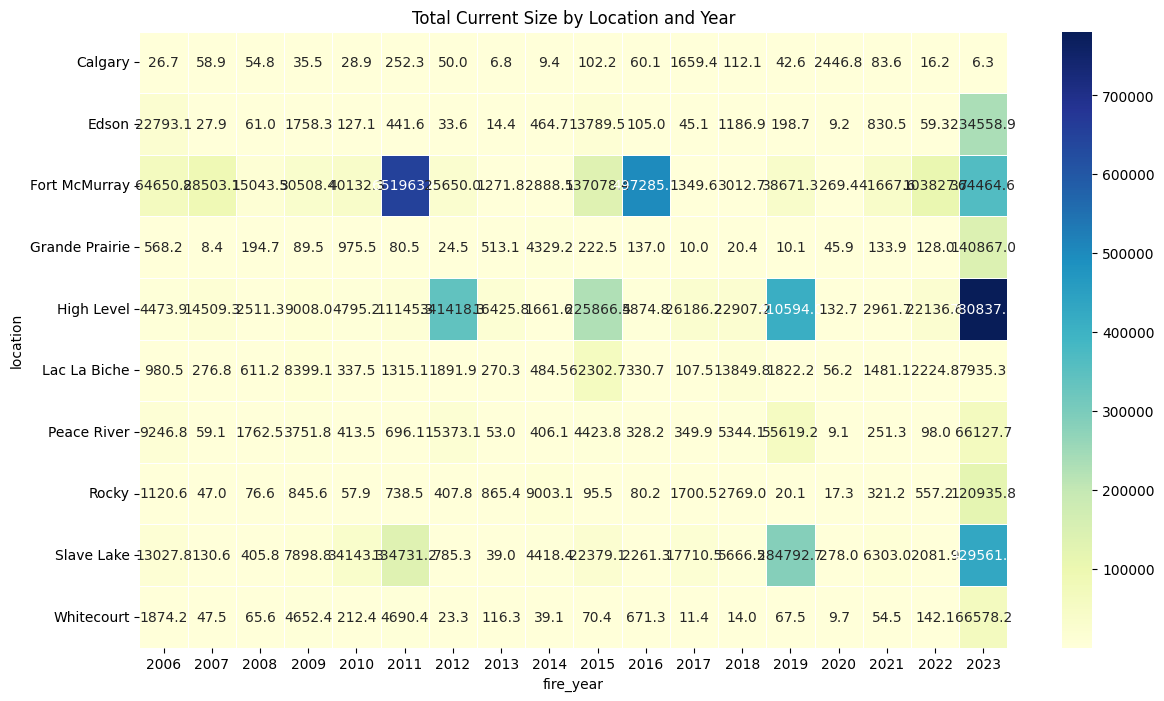

In [8]:
# Group by 'location' and 'fire_year' and calculate the total current_size
grouped_location_year = data.groupby(['location', 'fire_year']).agg({'current_size': 'sum'}).reset_index()

# Pivot the table to get years as columns and locations as rows
pivot_table = grouped_location_year.pivot(index='location', columns='fire_year', values='current_size')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Total Current Size by Location and Year')
plt.show()

Between 2006 and 2023, Fort McMurray, High Level, and Slave Lake experienced the highest amounts of area burned due to wildfires. In 2023, there was a noticeable increase in the size of areas burned across the majority of locations compared to previous years.

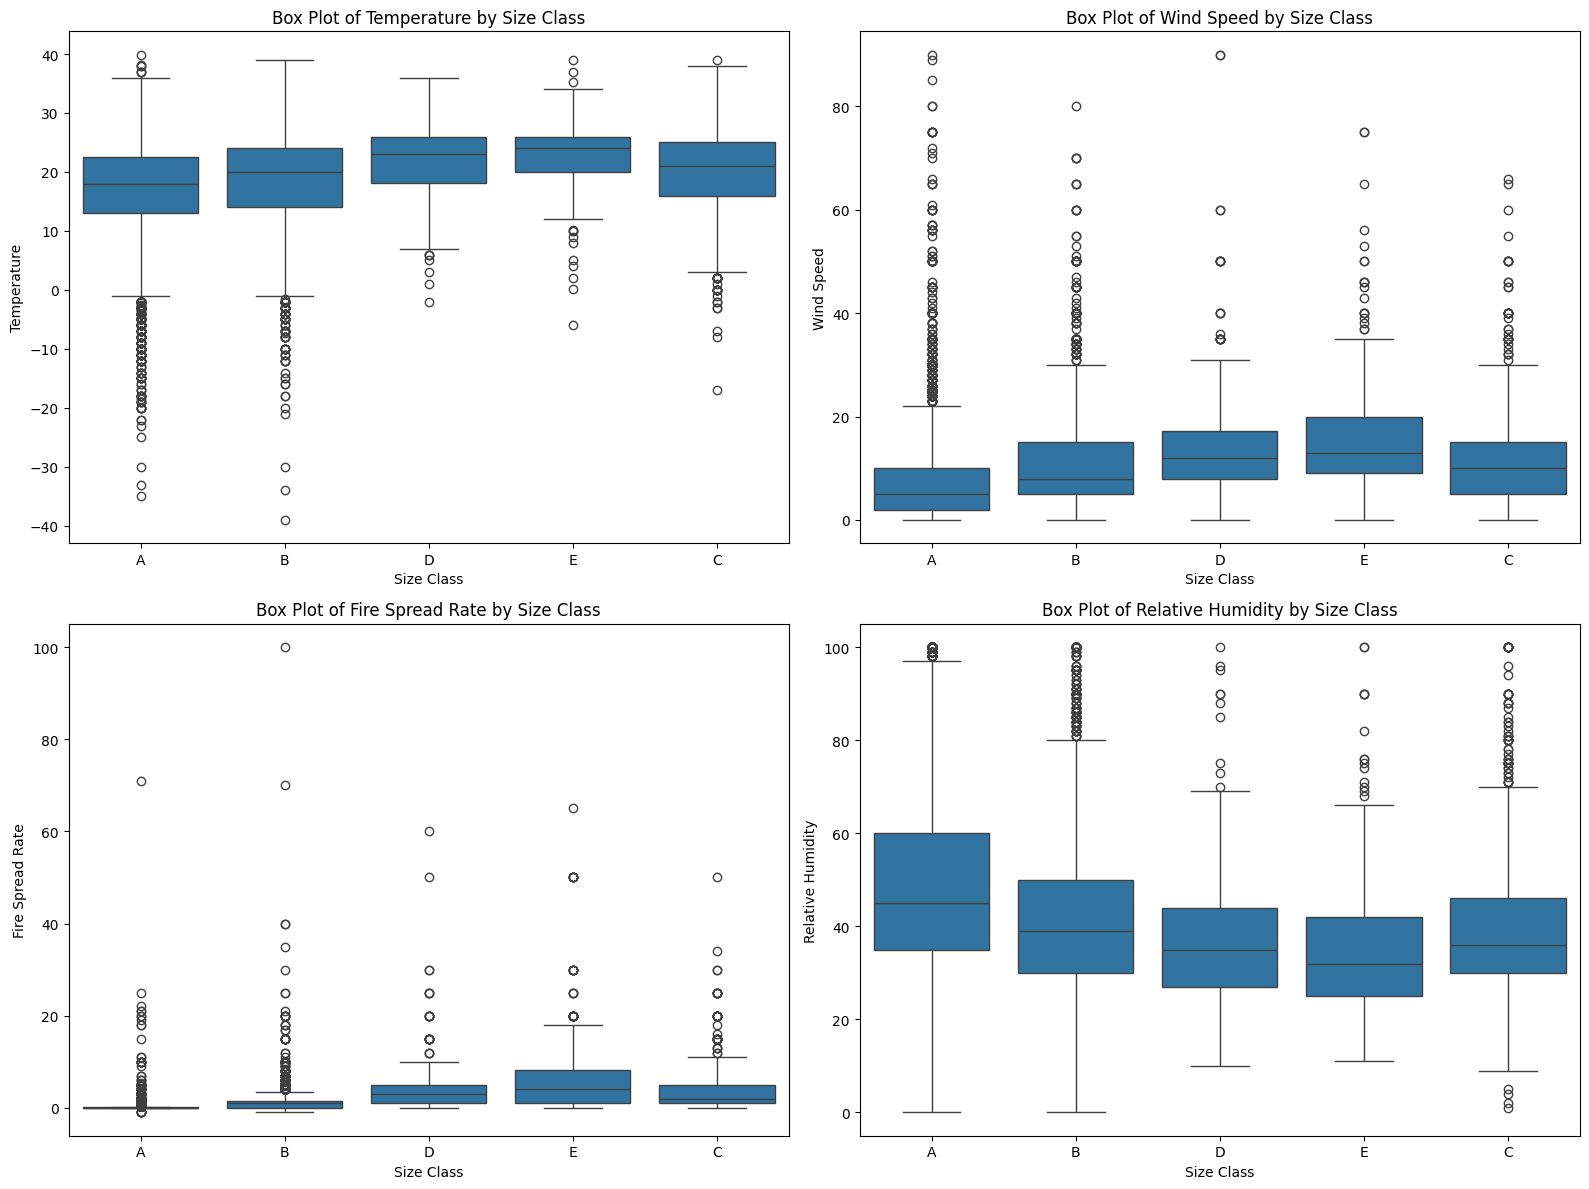

In [9]:
# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Create a box plot for temperature by size_class
sns.boxplot(x='size_class', y='temperature', data=data, ax=axes[0, 0])
axes[0, 0].set_title('Box Plot of Temperature by Size Class')
axes[0, 0].set_xlabel('Size Class')
axes[0, 0].set_ylabel('Temperature')

# Create a box plot for wind_speed by size_class
sns.boxplot(x='size_class', y='wind_speed', data=data, ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Wind Speed by Size Class')
axes[0, 1].set_xlabel('Size Class')
axes[0, 1].set_ylabel('Wind Speed')

# Create a box plot for fire_spread_rate by size_class
sns.boxplot(x='size_class', y='fire_spread_rate', data=data, ax=axes[1, 0])
axes[1, 0].set_title('Box Plot of Fire Spread Rate by Size Class')
axes[1, 0].set_xlabel('Size Class')
axes[1, 0].set_ylabel('Fire Spread Rate')

# Create a box plot for relative_humidity by size_class
sns.boxplot(x='size_class', y='relative_humidity', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of Relative Humidity by Size Class')
axes[1, 1].set_xlabel('Size Class')
axes[1, 1].set_ylabel('Relative Humidity')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Additionally, the data reveals a correlation between fire size class and environmental factors such as temperature, wind speed, and relative humidity. Specifically, larger fire size classes (Class E) are associated with higher temperatures, higher wind speeds, and lower humidity levels. However, there are some notable outliers:

Class A and B show variability in temperature and wind speed.
Class B and C display more outliers in terms of relative humidity.
Furthermore, as the fire size class increases, there is a corresponding increase in the fire spread rate. This indicates that larger fires tend to spread more rapidly, influenced by the more extreme environmental conditions they occur under.

Comparison of Total Current Size and Number of Fires by Year:
    fire_year  current_size  count
0        2006     118761.87   1954
1        2007     103668.54   1348
2        2008      20786.91   1712
3        2009      66947.44   1710
4        2010      81223.74   1840
5        2011     806054.64   1218
6        2012     385657.86   1568
7        2013      19575.84   1226
8        2014      23704.53   1470
9        2015     466330.48   1898
10       2016     507134.11   1376
11       2017      49130.33   1244
12       2018      54882.68   1279
13       2019     791838.41   1005
14       2020       3274.45    723
15       2021      54088.58   1342
16       2022     131271.77   1276
17       2023    2211873.23   1132


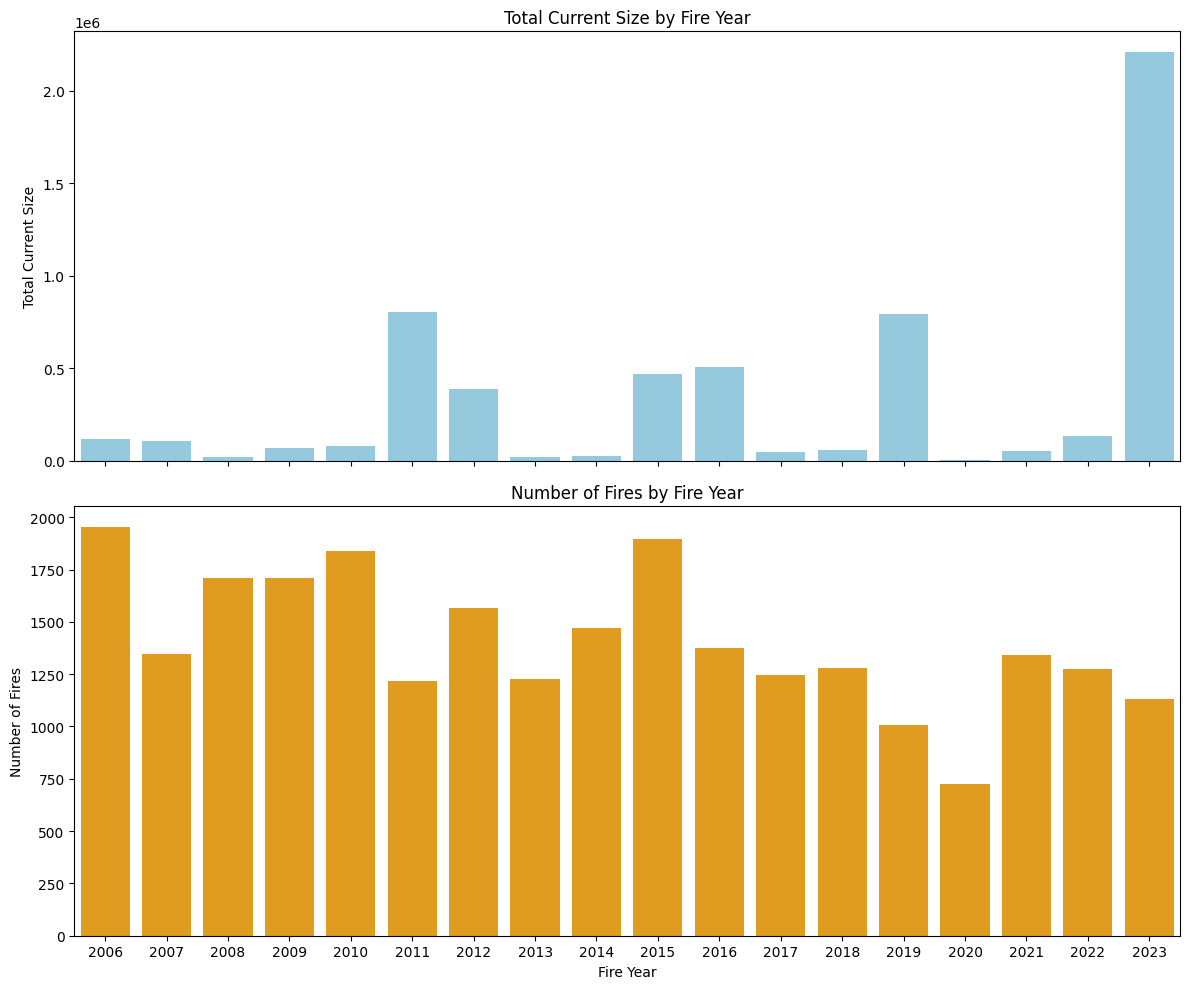

In [10]:
# Group by fire_year and calculate the mean current_size and count of items
grouped_df = data.groupby('fire_year').agg({'current_size': 'sum', 'size_class': 'count'}).reset_index()
grouped_df.rename(columns={'size_class': 'count'}, inplace=True)

# Convert fire_year to integer (ensure it's already integer in your original dataframe)
grouped_df['fire_year'] = grouped_df['fire_year'].astype(int)

# Display as a table
print("Comparison of Total Current Size and Number of Fires by Year:")
print(grouped_df)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Bar plot for Total Current Size
sns.barplot(data=grouped_df, x='fire_year', y='current_size', ax=ax1, color='skyblue')
ax1.set_title('Total Current Size by Fire Year')
ax1.set_ylabel('Total Current Size')

# Bar plot for Number of Fires
sns.barplot(data=grouped_df, x='fire_year', y='count', ax=ax2, color='orange')
ax2.set_title('Number of Fires by Fire Year')
ax2.set_xlabel('Fire Year')
ax2.set_ylabel('Number of Fires')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

There was a substantial increase in the total area burned in 2023, which surpassed the previously high totals recorded in 2011 and 2019. Despite this increase in fire size, the number of fires has been on a decreasing trend over the past years. The number of fires reached its lowest point in 2020, with the second lowest in 2017. Interestingly, although the area burned in 2023 was the highest, the number of fires that year was the third lowest in recent history. This suggests that while fewer fires are occurring, they tend to be larger and more destructive.

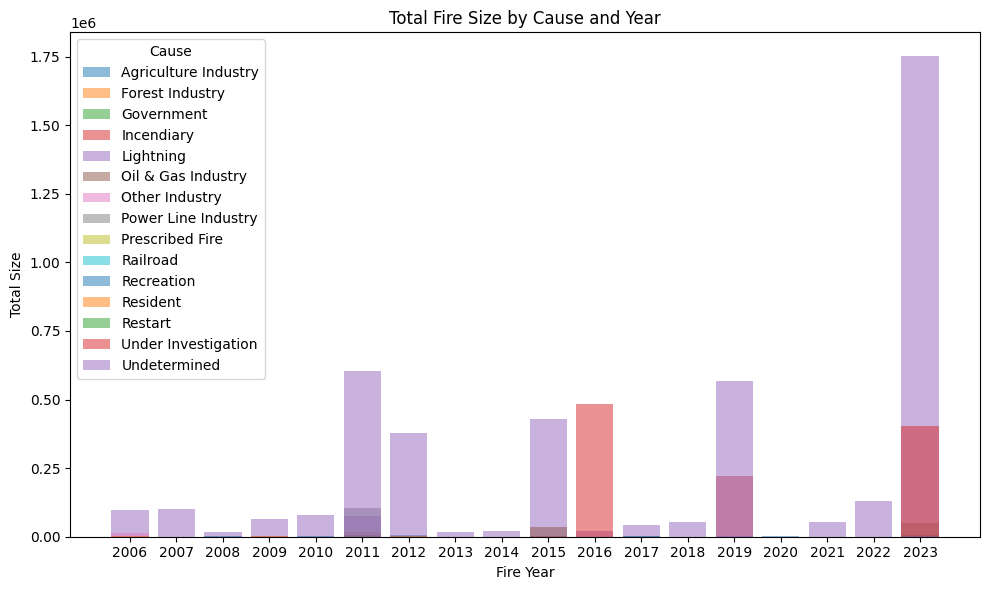

In [11]:
grouped_data = data.groupby(['general_cause_desc', 'fire_year'])['current_size'].sum().reset_index()

plt.figure(figsize=(10, 6)) 
# Iterate over unique general_cause_desc values for separate bars
for i, cause in enumerate(grouped_data['general_cause_desc'].unique()):
    plt.bar(
        grouped_data[grouped_data['general_cause_desc'] == cause]['fire_year'],
        grouped_data[grouped_data['general_cause_desc'] == cause]['current_size'],
        label=cause,
        alpha=0.5
    )

plt.xlabel('Fire Year')
plt.ylabel('Total Size')
plt.title('Total Fire Size by Cause and Year')
plt.xticks(grouped_data['fire_year'].unique())
plt.legend(title='Cause')

plt.tight_layout()
plt.show()


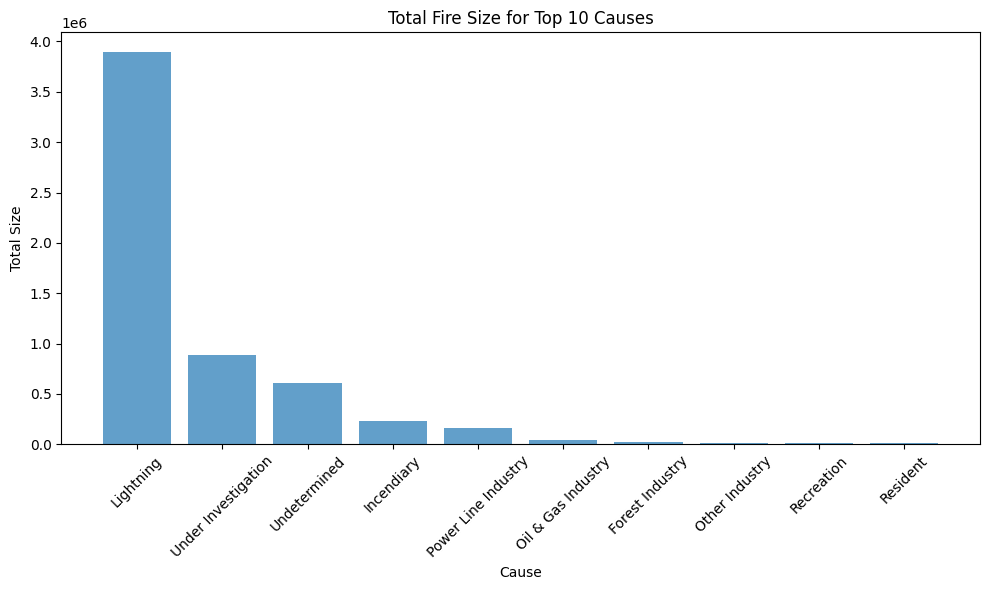

In [12]:
# Group by 'general_cause_desc' and sum the 'current_size' to get total size for each cause
total_size_by_cause = data.groupby('general_cause_desc')['current_size'].sum().reset_index()

# Identify the top 10 causes based on total size
top_5_causes = total_size_by_cause.nlargest(10, 'current_size')

# Plot the data for the top 10 causes
plt.figure(figsize=(10, 6))
plt.bar(top_5_causes['general_cause_desc'], top_5_causes['current_size'], alpha=0.7)

plt.xlabel('Cause')
plt.ylabel('Total Size')
plt.title('Total Fire Size for Top 10 Causes')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Basic Data Cleaning by Ray

In [13]:
data.shape

(25321, 52)

In [14]:
# Summary for missing values
# Adjusted code to display percentage of NA values for easier analysis

missing_summary = data.isna().sum()/len(data)*100

print("Summary of missing values for each column:")
print(missing_summary)

Summary of missing values for each column:
fire_year                        0.000000
fire_number                      0.000000
fire_name                       97.120967
current_size                     0.000000
size_class                       0.000000
fire_location_latitude           0.000000
fire_location_longitude          0.000000
fire_origin                      0.063189
general_cause_desc               0.000000
industry_identifier_desc        98.175428
responsible_group_desc          62.943802
activity_class                  38.596422
true_cause                      46.483156
fire_start_date                  2.689467
det_agent_type                   0.000000
det_agent                        0.000000
discovered_date                 19.513447
discovered_size                 99.423403
reported_date                    0.000000
dispatched_resource              0.067138
dispatch_date                    0.067138
start_for_fire_date              0.078986
assessment_resource              

In [15]:
columns_drop=[
'fire_year',                            # Redundant date column, the same information is available in the multiple other date columns. 
'fire_number',                          # useless column that is used as an indexing column
'fire_name',                            # 97.120967% missing values
'industry_identifier_desc',             # 98.175428% missing values
'true_cause',                           # 46.48% missing values
'ia_access',                            # 55.99% missing values
'activity_class',                       # 38.59% missing values
'discovered_size',                      # important column, but has 99% missing values
'responsible_group_desc',               # 62% missing values
'distance_from_water_source',           # 71.98% missing values
'first_bucket_drop_date',               # 71.97% missing values
'to_fs_date',                           # 89.55% missing values
'to_hectares'                           # 89.55% missing values
]
clean_na=data.drop(columns=columns_drop)

In [16]:
# Convert date columns to datetime
date_columns = ['fire_start_date', 
                'discovered_date', 
                'reported_date', 
                'start_for_fire_date', 
                'dispatch_date', 
                'assessment_datetime',
                'ia_arrival_at_fire_date', 
                'fire_fighting_start_date', 
                 'bh_fs_date', 
                 'uc_fs_date', 
                 'ex_fs_date']

# Convert each column to datetime
for col in date_columns:
    clean_na[col] = pd.to_datetime(clean_na[col], errors='coerce')

In [17]:
#Code column to binary for data analysis
clean_na['bucketing_on_fire']=clean_na['bucketing_on_fire'].map({'Y': 1, 'N': 0})

In [18]:
# droppping rows with NA values
clean_na.dropna(inplace=True)
clean_na.drop(clean_na[clean_na['fire_start_date'].dt.year.isin([2000, 2004, 2005])].index, inplace=True)    #discovered we have few rows for 2000, 2004, 2005 so I removed them as our analysis is from 2006-2023, and those points are about 5 rows

clean_na.shape

(11041, 39)

In [19]:
clean_na.dtypes

current_size                           float64
size_class                              object
fire_location_latitude                 float64
fire_location_longitude                float64
fire_origin                             object
general_cause_desc                      object
fire_start_date                 datetime64[ns]
det_agent_type                          object
det_agent                               object
discovered_date                 datetime64[ns]
reported_date                   datetime64[ns]
dispatched_resource                     object
dispatch_date                   datetime64[ns]
start_for_fire_date             datetime64[ns]
assessment_resource                     object
assessment_datetime             datetime64[ns]
assessment_hectares                    float64
fire_spread_rate                       float64
fire_type                               object
fire_position_on_slope                  object
weather_conditions_over_fire            object
temperature  

In [20]:
ann_data=clean_na.copy()
seda=clean_na.copy()
linear_reg=clean_na.copy()

## Classification - KNN

In [21]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


In [22]:
classification_data = clean_na


In [23]:
datetime_columns = classification_data.select_dtypes(include=['datetime64']).columns
for column in datetime_columns:
    classification_data[column + '_year'] = classification_data[column].dt.year
    classification_data[column + '_month'] = classification_data[column].dt.month
    classification_data[column + '_day'] = classification_data[column].dt.day
    classification_data[column + '_hour'] = classification_data[column].dt.hour
    classification_data = classification_data.drop(columns=[column])

# Tranform data
label_encoders = {}
for column in classification_data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    classification_data[column] = label_encoders[column].fit_transform(classification_data[column])


classification_data.dtypes

current_size               float64
size_class                   int32
fire_location_latitude     float64
fire_location_longitude    float64
fire_origin                  int32
                            ...   
uc_fs_date_hour              int32
ex_fs_date_year              int32
ex_fs_date_month             int32
ex_fs_date_day               int32
ex_fs_date_hour              int32
Length: 72, dtype: object

In [24]:
# Separate the features (X) and the target (y)
X = classification_data.drop(columns = ['size_class'])
y = classification_data['size_class']
y = LabelEncoder().fit_transform(y)

# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# To find the best k-value
# Define k-value range
param_grid = {'n_neighbors': range(1, 15)}

grid_search = GridSearchCV(knn, param_grid, cv=3)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

Best k value: 14


In [25]:
#Using the best k-value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

# Evluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.5613399728383884
Confusion Matrix:
[[847 284  11   5   4]
 [430 346   9   4   5]
 [ 39  94   7   2   5]
 [  5  21  18   5   4]
 [  9   4  11   5  35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.74      0.68      1151
           1       0.46      0.44      0.45       794
           2       0.12      0.05      0.07       147
           3       0.24      0.09      0.14        53
           4       0.66      0.55      0.60        64

    accuracy                           0.56      2209
   macro avg       0.42      0.37      0.39      2209
weighted avg       0.53      0.56      0.54      2209



#### Variation - Standardize

In [26]:
# Standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# To find the best k-value
# Define k-value range
param_grid = {'n_neighbors': range(1, 15)}
grid_search = GridSearchCV(knn, param_grid, cv=3)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

Best k value: 12


In [27]:
#Using the best k-value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

# Performance evluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.606156631960163
Confusion Matrix:
[[967 184   0   0   0]
 [444 344   6   0   0]
 [ 44  91  11   0   1]
 [ 13  28   8   1   3]
 [  8  28   8   4  16]]
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.84      0.74      1151
           1       0.51      0.43      0.47       794
           2       0.33      0.07      0.12       147
           3       0.20      0.02      0.03        53
           4       0.80      0.25      0.38        64

    accuracy                           0.61      2209
   macro avg       0.50      0.32      0.35      2209
weighted avg       0.57      0.61      0.57      2209



#### Variation - Droping datetime data

In [28]:
classification_withoutdatatime = clean_na

In [29]:
datetime_columns = classification_withoutdatatime.select_dtypes(include=['datetime64']).columns
for column in datetime_columns:
    classification_withoutdatatime = classification_withoutdatatime.drop(columns=[column])

label_encoders = {}
for column in classification_withoutdatatime.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    classification_withoutdatatime[column] = label_encoders[column].fit_transform(classification_withoutdatatime[column])


In [30]:
# Separate the features (X) and the target (y)
X = classification_withoutdatatime.drop(columns = ['size_class'])
y = classification_withoutdatatime['size_class']
y = LabelEncoder().fit_transform(y)

# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# To find the best k-value
# Define k-value range
param_grid = {'n_neighbors': range(1, 15)}
grid_search = GridSearchCV(knn, param_grid, cv=3)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")


#Using the best k-value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

# Performance evluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Best k value: 2
Accuracy: 0.5536441828881847
Confusion Matrix:
[[950 188  11   1   1]
 [579 205   8   0   2]
 [ 55  75  17   0   0]
 [ 10   7  22  13   1]
 [  3   6   3  14  38]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.83      0.69      1151
           1       0.43      0.26      0.32       794
           2       0.28      0.12      0.16       147
           3       0.46      0.25      0.32        53
           4       0.90      0.59      0.72        64

    accuracy                           0.55      2209
   macro avg       0.53      0.41      0.44      2209
weighted avg       0.52      0.55      0.52      2209



## Neural Networks



In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [32]:
# Separate the features (X) and the target (y)
X = classification_data.drop(columns=['size_class'])
y = classification_data['size_class']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Determine the number of input features
input_size = X_train.shape[1]


In [33]:
# Neural network model
# 5 layers
class SimpleNNClassification(nn.Module):
    def __init__(self, input_size):
        super(SimpleNNClassification, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 5) 
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
model_class = SimpleNNClassification(input_size)
criterion_class = nn.CrossEntropyLoss()
optimizer_class = optim.Adam(model_class.parameters(), lr=0.001)

In [34]:
# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model_class.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer_class.zero_grad()
        outputs = model_class(inputs)
        loss = criterion_class(outputs, targets)
        loss.backward()
        optimizer_class.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluation
model_class.eval()
with torch.no_grad():
    test_outputs = model_class(X_test_tensor)
    _, predicted_classes = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test_tensor, predicted_classes)
    test_conf_matrix = confusion_matrix(y_test_tensor, predicted_classes)

print(f'Test Accuracy: {test_accuracy}')
print('Confusion Matrix:')
print(test_conf_matrix)


Epoch 1/20, Loss: 1.0199099401201026
Epoch 2/20, Loss: 0.7958747956199922
Epoch 3/20, Loss: 0.7435778313572856
Epoch 4/20, Loss: 0.7084745086621547
Epoch 5/20, Loss: 0.6820207282468893
Epoch 6/20, Loss: 0.66198372527741
Epoch 7/20, Loss: 0.6428692608639814
Epoch 8/20, Loss: 0.6270913170731586
Epoch 9/20, Loss: 0.614284289487894
Epoch 10/20, Loss: 0.6018415999369345
Epoch 11/20, Loss: 0.590022800517255
Epoch 12/20, Loss: 0.5757797161738077
Epoch 13/20, Loss: 0.5685434348989225
Epoch 14/20, Loss: 0.5565487324543621
Epoch 15/20, Loss: 0.5439833111089208
Epoch 16/20, Loss: 0.5341909242712933
Epoch 17/20, Loss: 0.5257079933864482
Epoch 18/20, Loss: 0.5175979085590529
Epoch 19/20, Loss: 0.510986904087274
Epoch 20/20, Loss: 0.5066886143623919
Test Accuracy: 0.7297419646899049
Confusion Matrix:
[[875 276   0   0   0]
 [180 575  36   3   0]
 [  3  40  86  15   3]
 [  0   4  25  18   6]
 [  0   0   1   5  58]]


#### Variation - Droping datetime data

In [35]:
# Split into features and target
X = classification_withoutdatatime.drop(columns=['size_class'])
y = classification_withoutdatatime['size_class']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the data 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Determine the number of input features
input_size = X_train.shape[1]

# Neural network model
# 5 layers
class SimpleNNClassification(nn.Module):
    def __init__(self, input_size):
        super(SimpleNNClassification, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 5)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
model_class = SimpleNNClassification(input_size)
criterion_class = nn.CrossEntropyLoss()
optimizer_class = optim.Adam(model_class.parameters(), lr=0.001)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model_class.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer_class.zero_grad()
        outputs = model_class(inputs)
        loss = criterion_class(outputs, targets)
        loss.backward()
        optimizer_class.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Evluation
model_class.eval()
with torch.no_grad():
    test_outputs = model_class(X_test_tensor)
    _, predicted_classes = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test_tensor, predicted_classes)
    test_conf_matrix = confusion_matrix(y_test_tensor, predicted_classes)

print(f'Test Accuracy: {test_accuracy}')
print('Confusion Matrix:')
print(test_conf_matrix)



Epoch 1/20, Loss: 0.9760935405890147
Epoch 2/20, Loss: 0.7850464235829271
Epoch 3/20, Loss: 0.7276239962033604
Epoch 4/20, Loss: 0.6856308430433273
Epoch 5/20, Loss: 0.6587710453980211
Epoch 6/20, Loss: 0.635227392765059
Epoch 7/20, Loss: 0.6159093087350113
Epoch 8/20, Loss: 0.60501745969489
Epoch 9/20, Loss: 0.589067353286605
Epoch 10/20, Loss: 0.5771770138239515
Epoch 11/20, Loss: 0.564344374489957
Epoch 12/20, Loss: 0.5531410175389138
Epoch 13/20, Loss: 0.5450225226257158
Epoch 14/20, Loss: 0.532302443208038
Epoch 15/20, Loss: 0.5266911819361259
Epoch 16/20, Loss: 0.516410450356594
Epoch 17/20, Loss: 0.5147982739667961
Epoch 18/20, Loss: 0.49584383981815283
Epoch 19/20, Loss: 0.49598507788302243
Epoch 20/20, Loss: 0.4860181491552056
Test Accuracy: 0.7197827071072883
Confusion Matrix:
[[1003  146    2    0    0]
 [ 314  443   37    0    0]
 [   4   56   73   14    0]
 [   0    4   27   17    5]
 [   0    1    5    4   54]]


## SVM

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [37]:

# Split into features and target
X = classification_data.drop(columns=['size_class'])
y =  classification_data['size_class']

# Standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the datframe
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Prediction
y_pred = svm_model.predict(X_test)

# Evluation
test_accuracy = accuracy_score(y_test, y_pred)
test_conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Confusion Matrix:')
print(test_conf_matrix)


Test Accuracy: 0.7157084653689453
Confusion Matrix:
[[1043  107    1    0    0]
 [ 354  432    8    0    0]
 [   8   87   47    5    0]
 [   2   18   16   13    4]
 [   1    3    8    6   46]]


#### Variation - Droping datetime data

In [38]:

# Split into features and target
X = classification_withoutdatatime.drop(columns=['size_class'])
y =  classification_withoutdatatime['size_class']

# Standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the datframe
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Prediction
y_pred = svm_model.predict(X_test)

# Evluation
test_accuracy = accuracy_score(y_test, y_pred)
test_conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Confusion Matrix:')
print(test_conf_matrix)


Test Accuracy: 0.6894522408329561
Confusion Matrix:
[[1044  107    0    0    0]
 [ 393  398    3    0    0]
 [  10  107   30    0    0]
 [   1   30   16    6    0]
 [   2   10    4    3   45]]


## Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
#from sklearn.tree import export_graphviz
#import graphviz
#from dtreeviz.trees import dtreeviz
from IPython.display import Image
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [40]:
columns_to_keep = ['size_class', 'fire_origin', 'general_cause_desc',
       'det_agent_type', 'det_agent', 'dispatched_resource',
       'assessment_resource', 'assessment_hectares', 'fire_spread_rate',
       'fire_type', 'fire_position_on_slope', 'weather_conditions_over_fire',
       'temperature', 'relative_humidity', 'wind_direction', 'wind_speed',
       'fuel_type', 'initial_action_by', 'fire_fighting_start_size',
       'bucketing_on_fire', 'fire_start_date_year',
       'fire_start_date_month', 'fire_start_date_day', 'fire_start_date_hour',
       'discovered_date_year', 'discovered_date_month', 'discovered_date_day',
       'discovered_date_hour', 'reported_date_year', 'reported_date_month',
       'reported_date_day', 'reported_date_hour', 'assessment_datetime_year', 'assessment_datetime_month',
       'assessment_datetime_day', 'assessment_datetime_hour','location'
       ]
rf_data = classification_data[columns_to_keep]

In [41]:
display(rf_data)

,size_class,fire_origin,general_cause_desc,det_agent_type,det_agent,dispatched_resource,assessment_resource,assessment_hectares,fire_spread_rate,fire_type,...,discovered_date_hour,reported_date_year,reported_date_month,reported_date_day,reported_date_hour,assessment_datetime_year,assessment_datetime_month,assessment_datetime_day,assessment_datetime_hour,location
9,1,1,11,4,105,1,2,0.60,0.0,3,...,16,2006,4,4,16,2006,4,4,16,5
10,0,5,4,4,0,3,1,0.01,0.0,2,...,12,2006,7,3,13,2006,7,3,15,7
12,0,5,4,0,107,4,1,0.01,1.0,3,...,17,2006,7,22,17,2006,7,22,17,9
15,0,5,4,3,21,3,1,0.01,0.0,3,...,12,2006,7,30,12,2006,7,30,12,7
17,3,5,4,3,19,3,1,2.00,12.0,1,...,16,2006,7,4,16,2006,7,4,16,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25306,1,5,4,4,78,3,1,0.20,1.0,2,...,15,2023,7,31,15,2023,7,31,15,0
25307,1,1,3,4,57,2,1,0.20,0.0,3,...,16,2023,7,31,16,2023,7,31,17,0
25312,0,5,4,3,24,3,1,0.01,1.0,3,...,15,2023,6,28,15,2023,6,28,15,6
25313,0,5,4,3,94,3,1,0.01,1.0,3,...,18,2023,6,28,18,2023,6,28,19,6


In [42]:
# Split the data into features (X) and target (y) as size_class
X = rf_data.drop('size_class', axis=1)
y = rf_data['size_class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
# Fitting the model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
y_pred = rf.predict(X_test)

In [45]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8537799909461294


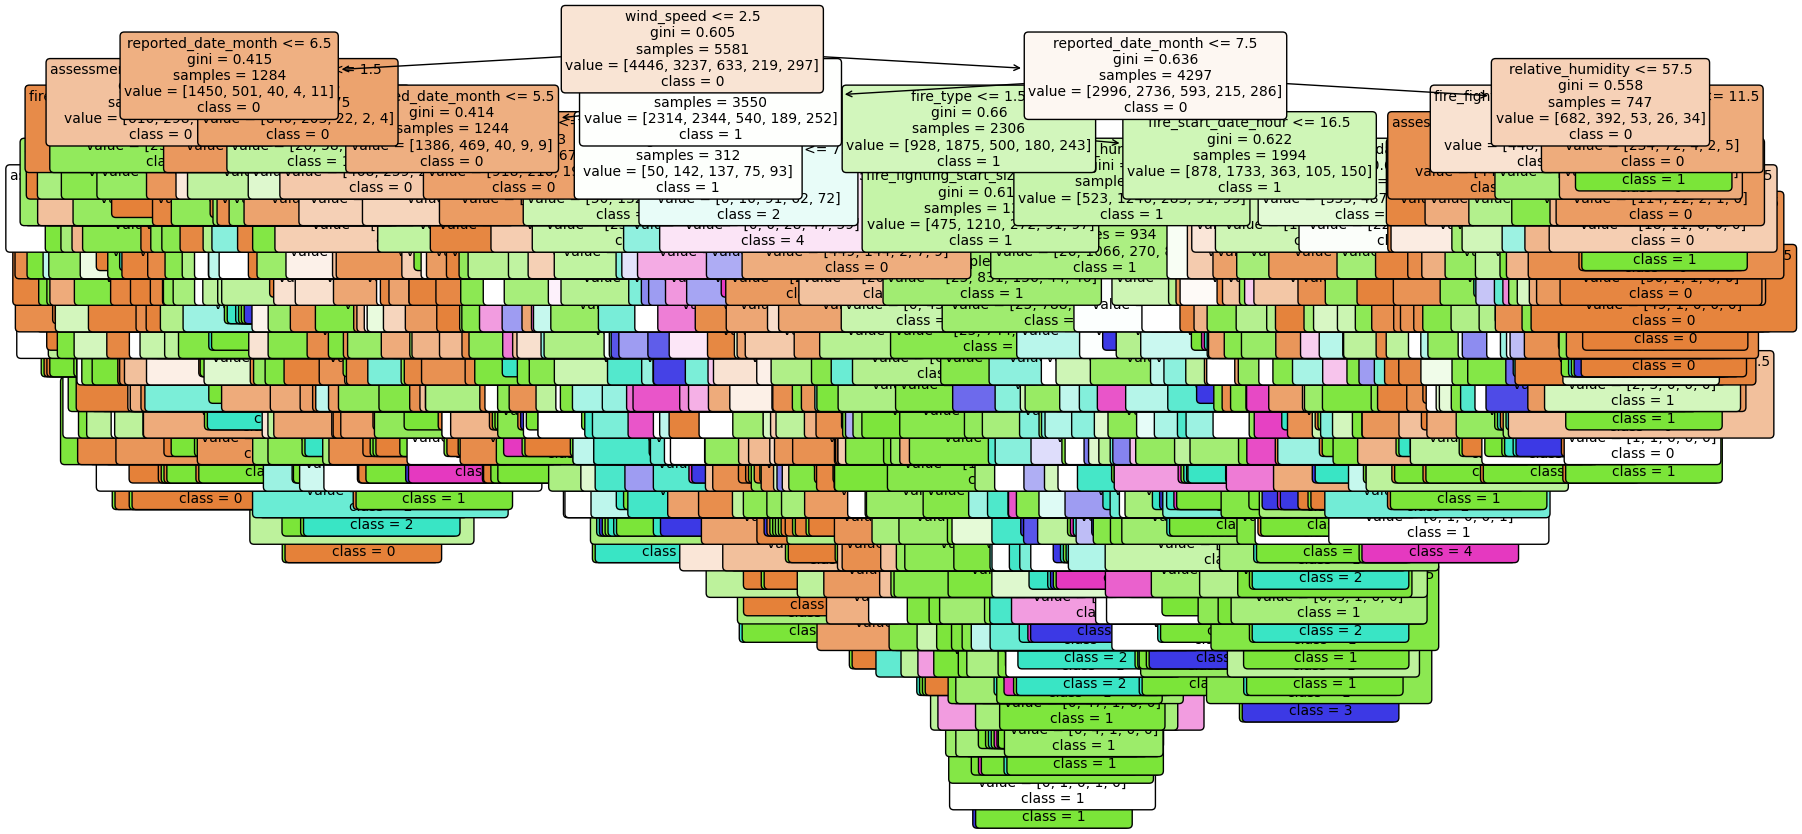

In [46]:
# Visualizing one of the trees from the forest
# Select the first tree
estimator = rf.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=X.columns, class_names=rf.classes_.astype(str), filled=True, rounded=True, fontsize=10)
plt.show()

In [47]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A7392DEA50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A73918FFD0>})

In [48]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 426}


In [49]:
best_params = {'max_depth': 15, 'n_estimators': 319}

# Create and fit the optimized model
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)

# Predict the labels for the test set using the optimized model
y_pred_optimized = best_rf.predict(X_test)

# Calculate the accuracy of the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print("Accuracy of the optimized model:", accuracy_optimized)



Accuracy of the optimized model: 0.8537799909461294


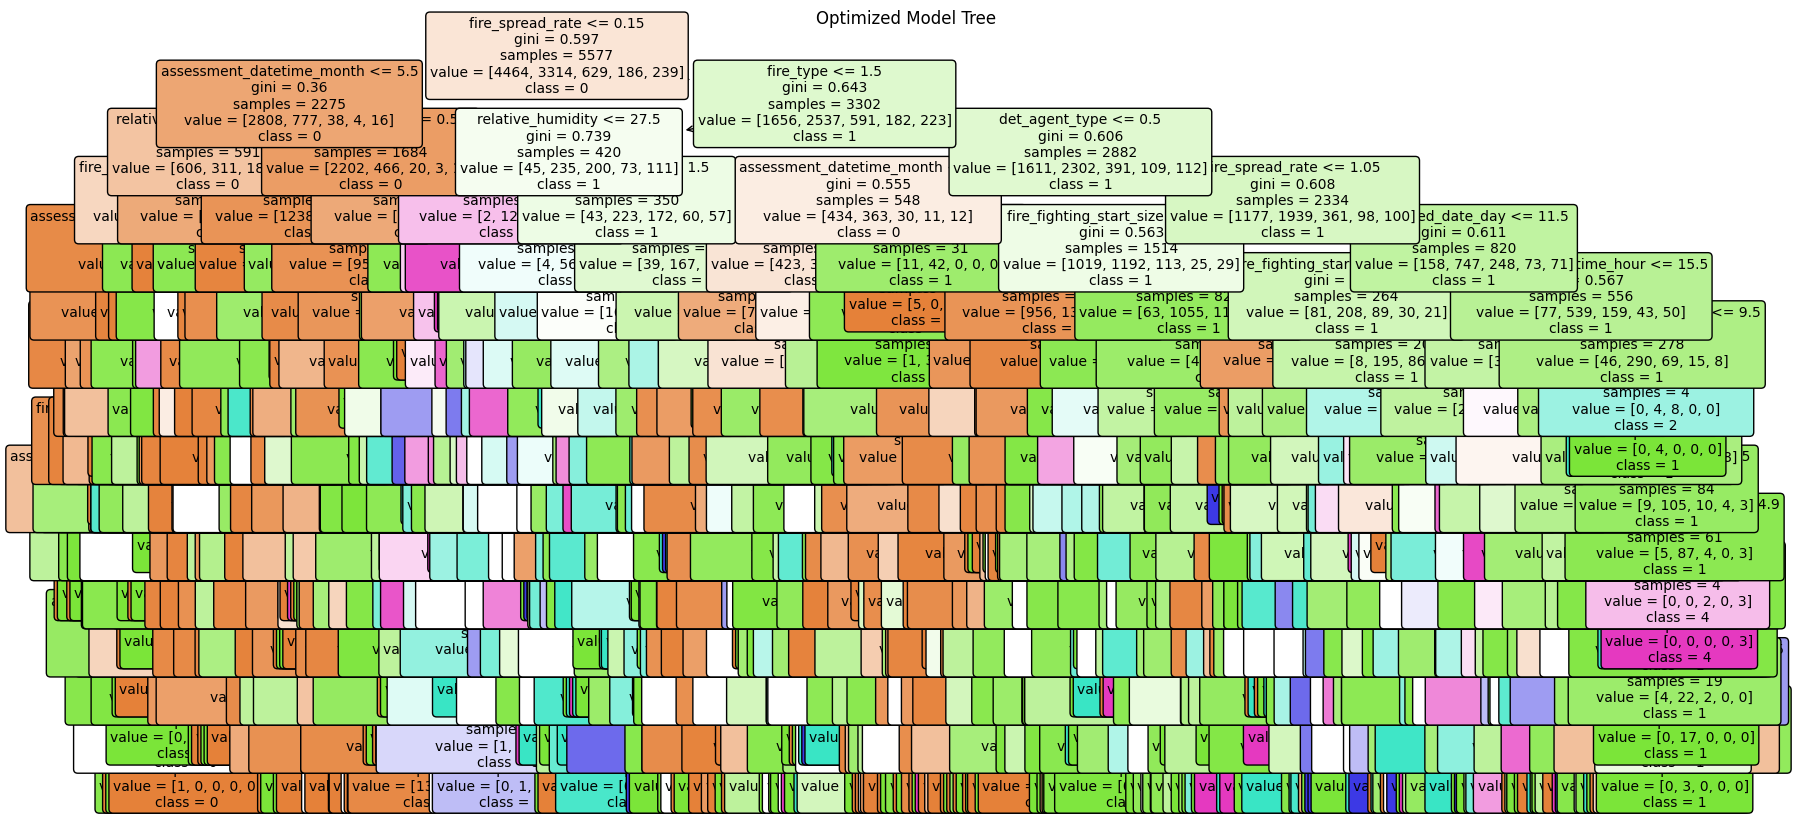

In [50]:
# Visualizing one of the optimized trees
estimator_optimized = best_rf.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(estimator_optimized, feature_names=X.columns, class_names=best_rf.classes_.astype(str), filled=True, rounded=True, fontsize=10)
plt.title("Optimized Model Tree")
plt.show()

In [51]:
y_pred_optimized = best_rf.predict(X_test)

cm_optimized = confusion_matrix(y_test, y_pred_optimized)
print("Confusion Matrix of the optimized model:\n", cm_optimized)

Confusion Matrix of the optimized model:
 [[1078   41    0    0    0]
 [  87  678   15    0    0]
 [   2   74  106    0    2]
 [   0   15   28    4   10]
 [   3   15   26    5   20]]


In [52]:
# Calculate and print the classification report
report = classification_report(y_test, y_pred_optimized)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      1119
           1       0.82      0.87      0.85       780
           2       0.61      0.58      0.59       184
           3       0.44      0.07      0.12        57
           4       0.62      0.29      0.40        69

    accuracy                           0.85      2209
   macro avg       0.68      0.55      0.58      2209
weighted avg       0.84      0.85      0.84      2209



## Time Series Analysis

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

### Time Series Analysis - "Current Size"

In [66]:
ts_data = clean_na.copy()

#ts_data['fire_start_date'] = pd.to_datetime(
#    ts_data[['start_for_fire_date_year', 'start_for_fire_date_month', 'start_for_fire_date_day']]
#    .rename(columns={
#        'start_for_fire_date_year': 'year',
#        'start_for_fire_date_month': 'month',
#        'start_for_fire_date_day': 'day'
#    })
#)

ts_data = ts_data[['fire_start_date','current_size']].copy()

# Set the fire_start_date as the index
ts_data.set_index('fire_start_date', inplace=True)
ts_data.sort_index(inplace=True)
ts_data = ts_data.resample('M').sum()

print(ts_data.head(10))

                 current_size
fire_start_date              
2006-01-31               0.30
2006-02-28            1789.24
2006-03-31               4.81
2006-04-30            2588.60
2006-05-31            1265.62
2006-06-30           90978.25
2006-07-31           14517.18
2006-08-31            1975.45
2006-09-30              59.81
2006-10-31              93.21


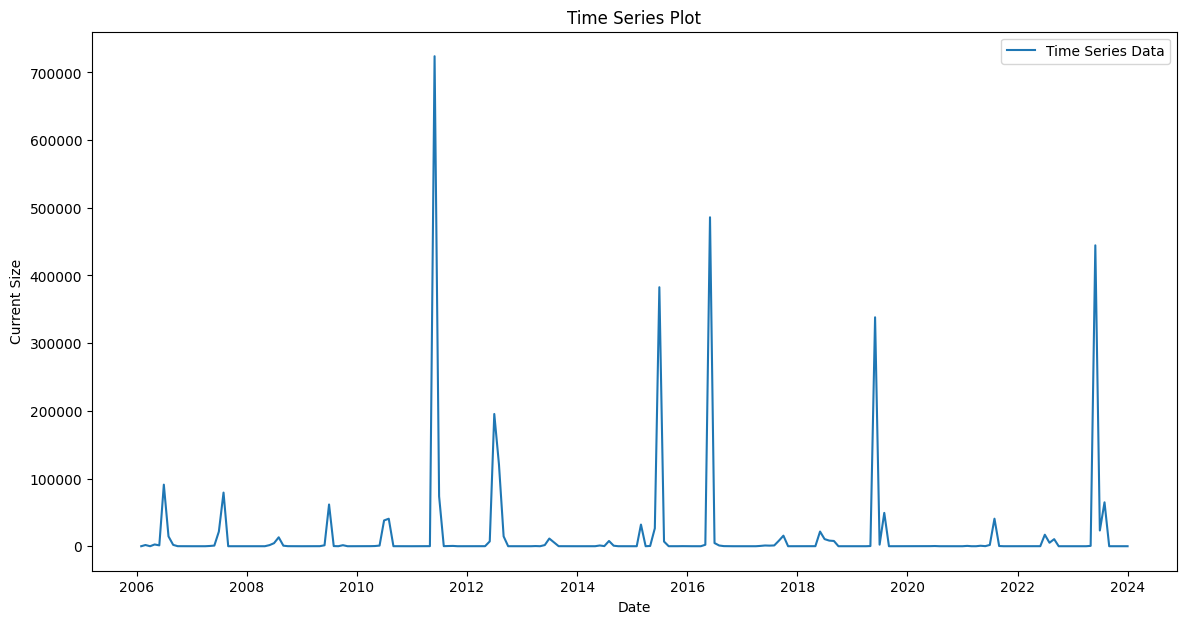

In [67]:
# Plot the time series
plt.figure(figsize=(14, 7))
plt.plot(ts_data.index, ts_data['current_size'], label='Time Series Data')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Current Size')
plt.legend()
plt.show()

In [68]:
# Stationery check
# Perform Augmented Dickey-Fuller test
result = adfuller(ts_data['current_size'])
print('ADF Statistic:', result[0])
print('p-value: {:.10f}'.format(result[1]))

for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

print('p-value is less than a significance level of 0.05, reject the null hypothesis. The series is stationary')


ADF Statistic: -13.954874396494763
p-value: 0.0000000000
Critical Values:
   1%, -3.461136478222043
Critical Values:
   5%, -2.875078880098608
Critical Values:
   10%, -2.5739861168199027
p-value is less than a significance level of 0.05, reject the null hypothesis. The series is stationary


<Figure size 1400x1000 with 0 Axes>

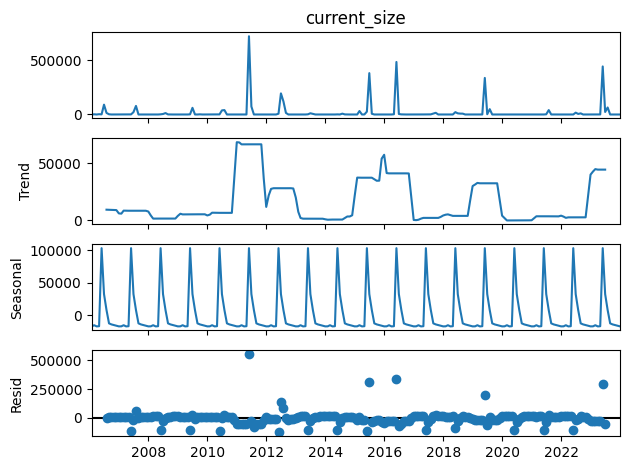

In [69]:
decomposition = seasonal_decompose(ts_data['current_size'], model='additive', period=12)
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.show()


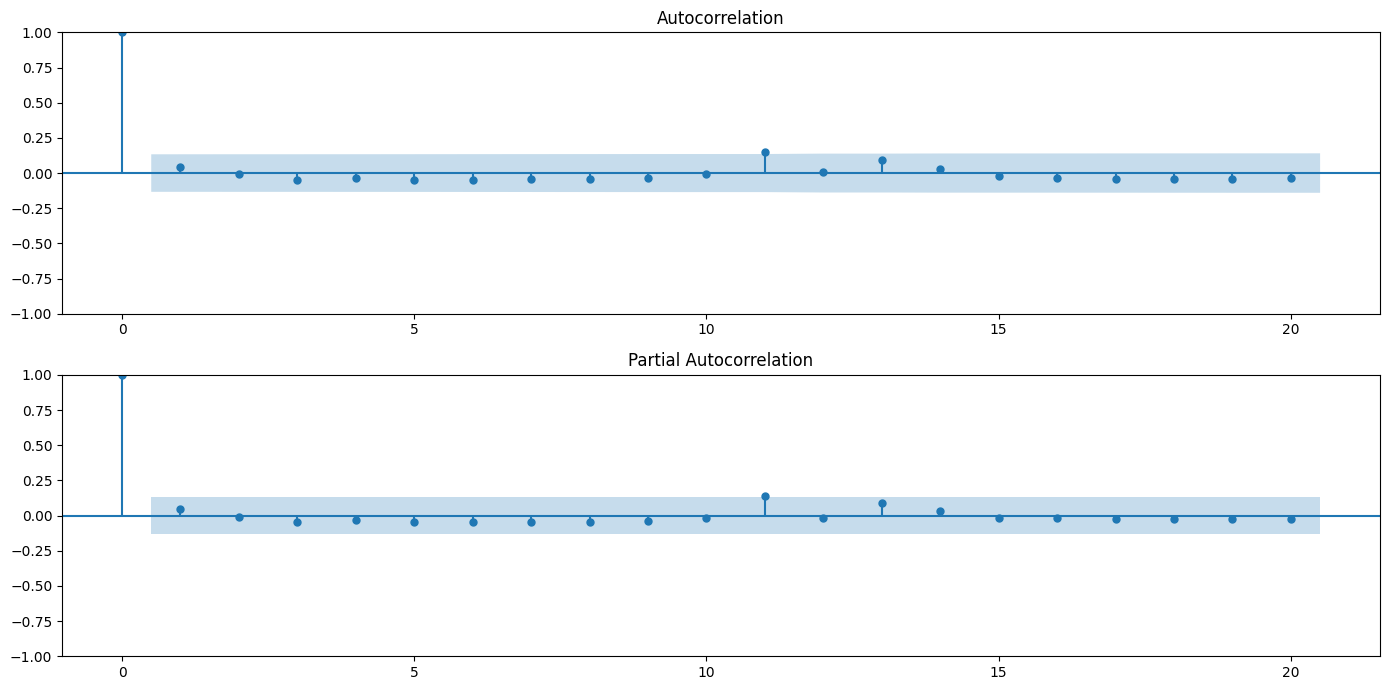

In [70]:
# Autocorrelation Function and Partial Autocorrelation Function 
plt.figure(figsize=(14, 7))

# ACF plot
ax1 = plt.subplot(211)
plot_acf(ts_data['current_size'], lags=20, ax=ax1)

# PACF plot
ax2 = plt.subplot(212)
plot_pacf(ts_data['current_size'], lags=20, ax=ax2)

plt.tight_layout()
plt.show()

In [71]:
# Fit SARIMA model
order = (1, 0, 1)  # (p, d, q)
seasonal_order = (1, 1, 0, 12)  # (P, D, Q, S) with S=12 for monthly data

sarima_model = SARIMAX(ts_data['current_size'], order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)
print(sarima_model_fit.summary())

# Calculate RSS (Residual Sum of Squares)
residuals = sarima_model_fit.resid
rss = sum(residuals**2)

print(rss)

                                      SARIMAX Results                                      
Dep. Variable:                        current_size   No. Observations:                  216
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood               -2627.715
Date:                             Wed, 10 Jul 2024   AIC                           5263.429
Time:                                     16:46:52   BIC                           5276.702
Sample:                                 01-31-2006   HQIC                          5268.798
                                      - 12-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3927     31.462      0.012      0.990     -61.271      62.056
ma.L1         -0.3856     3

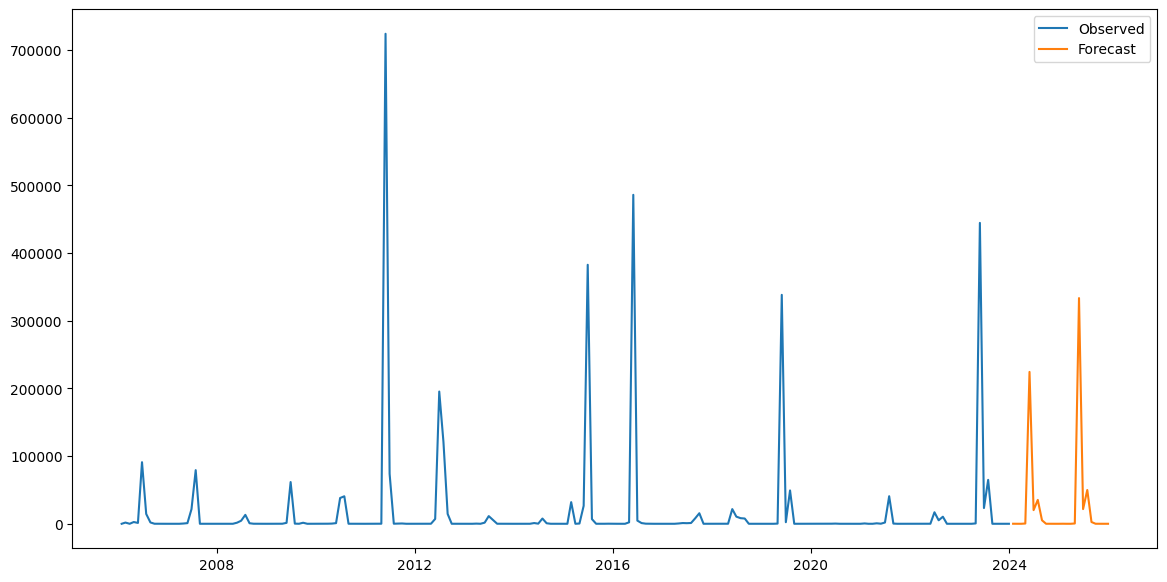

In [72]:
# Forecasting with the fitted SARIMA model for the next 2 years
forecast_steps = 24
forecast = sarima_model_fit.forecast(steps=forecast_steps)

# Plotting the forecast
plt.figure(figsize=(14, 7))
plt.plot(ts_data.index, ts_data['current_size'], label='Observed')
plt.plot(pd.date_range(start=ts_data.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label='Forecast')
plt.legend()
plt.show()

### Time Series Analysis - Fire Count

In [73]:
ts_data_count = clean_na.copy()

#ts_data_count['fire_start_date'] = pd.to_datetime(
#    ts_data_count[['start_for_fire_date_year', 'start_for_fire_date_month', 'start_for_fire_date_day']]
#    .rename(columns={
#        'start_for_fire_date_year': 'year',
#        'start_for_fire_date_month': 'month',
#        'start_for_fire_date_day': 'day'
#    })
#)

ts_data_count['month_year'] = ts_data_count['fire_start_date'].dt.to_period('M')
ts_data_count = ts_data_count.groupby('month_year').size().reset_index(name='fire_count')
ts_data_count.set_index('month_year', inplace=True)
ts_data_count.sort_index(inplace=True)\
 
print(ts_data_count.head(10))

            fire_count
month_year            
2006-01              1
2006-02              6
2006-03              6
2006-04            102
2006-05            128
2006-06            211
2006-07            364
2006-08             62
2006-09             42
2006-10             17


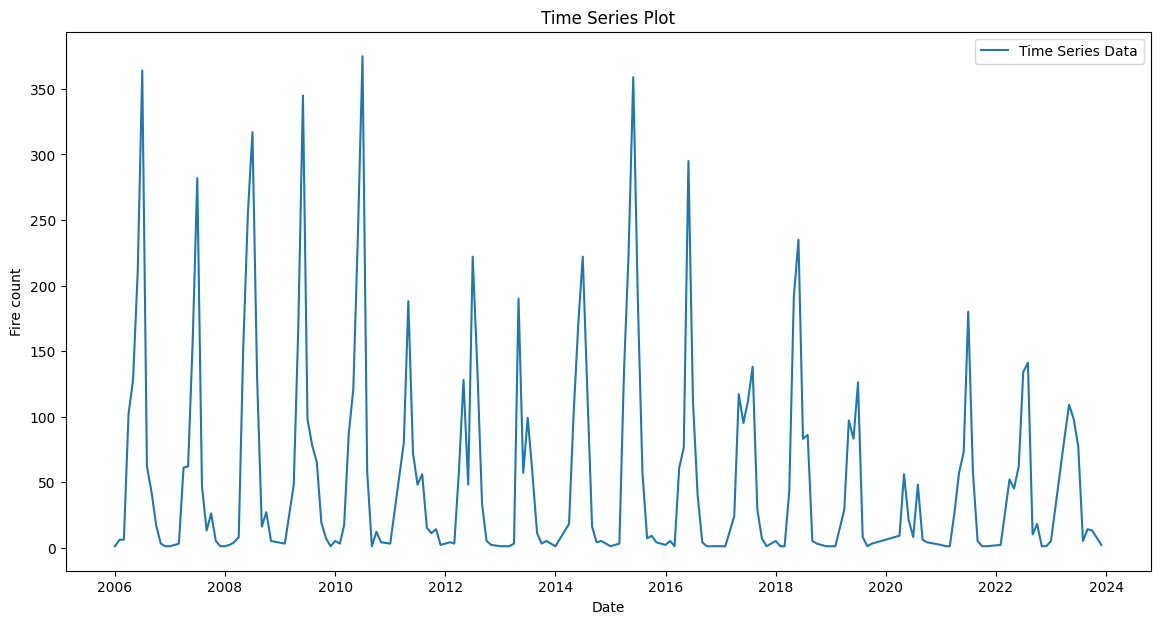

In [74]:
# Plot the time series
ts_data_count.index = ts_data_count.index.to_timestamp()

plt.figure(figsize=(14, 7))
plt.plot(ts_data_count.index, ts_data_count['fire_count'], label='Time Series Data')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Fire count')
plt.legend()
plt.show()

<Figure size 1400x1000 with 0 Axes>

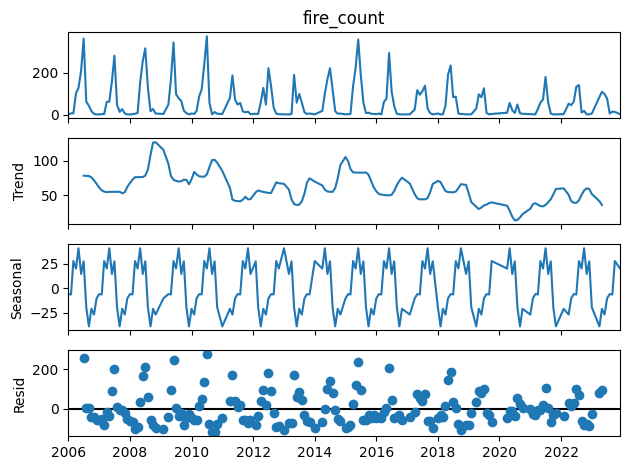

In [75]:
# Decomposing the Time Series
decomposition = seasonal_decompose(ts_data_count['fire_count'], model='additive', period=12)

plt.figure(figsize=(14, 10))
decomposition.plot()
plt.show()

In [76]:
# Perform ADF test for stationarity
result = adfuller(ts_data_count['fire_count'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])

print('p-value is significantly lower than 0.05, indicating the data is stationary, we can proceed with SARIMA modeling without further differencing.')

ADF Statistic: -3.083678733418838
p-value: 0.027784850866898636
p-value is significantly lower than 0.05, indicating the data is stationary, we can proceed with SARIMA modeling without further differencing.


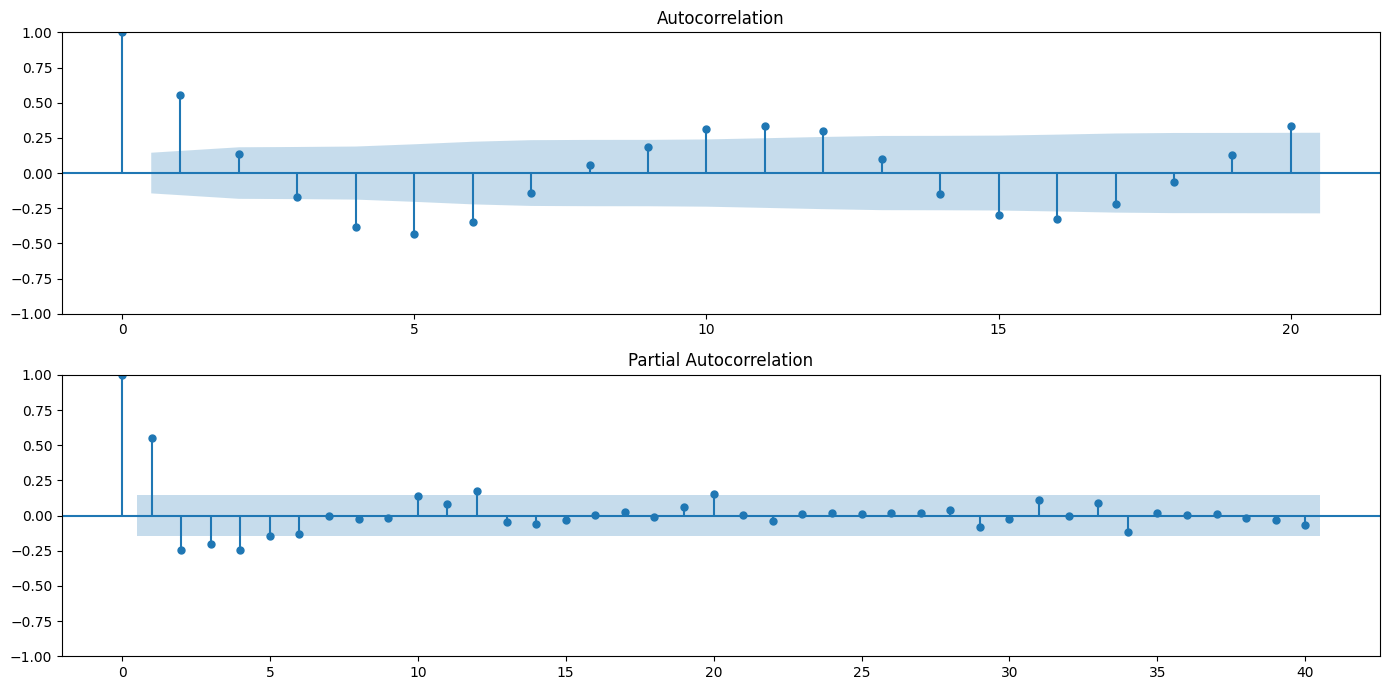

In [77]:
plt.figure(figsize=(14, 7))
# ACF plot
ax1 = plt.subplot(211)
plot_acf(ts_data_count['fire_count'], lags=20, ax=ax1)

# PACF plot
ax2 = plt.subplot(212)
plot_pacf(ts_data_count['fire_count'], lags=40, ax=ax2)

plt.tight_layout()

In [78]:
# SARIMA model fitting
countmodel = SARIMAX(ts_data_count['fire_count'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
countmodel_fit = countmodel.fit(disp=False)
print(countmodel_fit.summary())

C:\Users\gigic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\gigic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         fire_count   No. Observations:                  184
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -1039.303
Date:                            Wed, 10 Jul 2024   AIC                           2088.606
Time:                                    16:47:01   BIC                           2104.681
Sample:                                         0   HQIC                          2095.122
                                            - 184                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5190      0.119      4.364      0.000       0.286       0.752
ma.L1          0.1858      0.159   

C:\Users\gigic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\gigic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


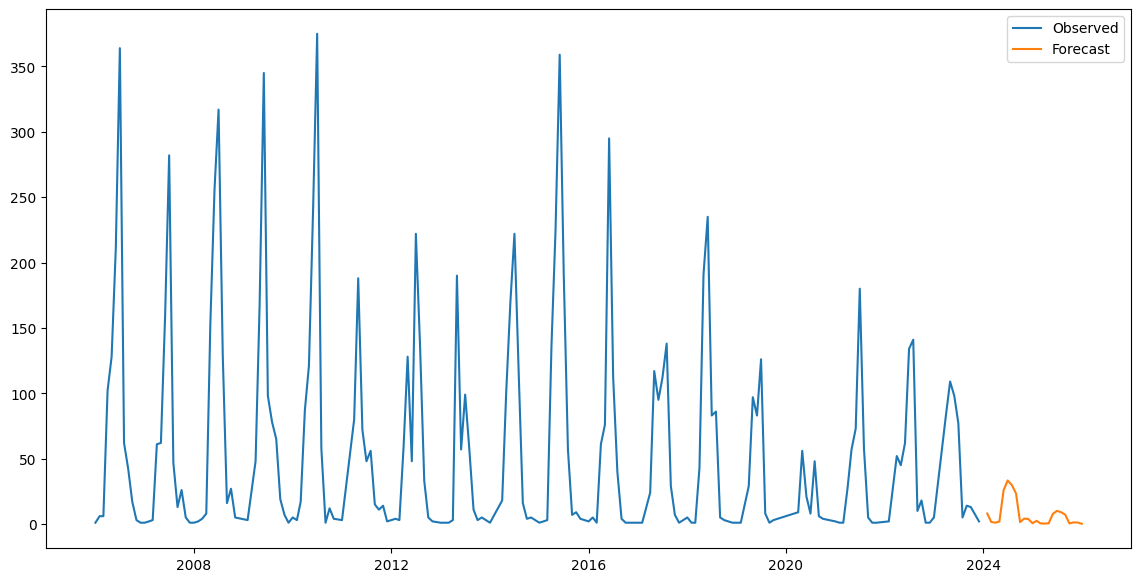

In [79]:
# Forecasting with the fitted SARIMA model for the next 2 years
forecast_steps = 24
forecast_count = countmodel_fit.forecast(steps=forecast_steps)

# Plotting the forecast
plt.figure(figsize=(14, 7))
plt.plot(ts_data_count.index, ts_data_count['fire_count'], label='Observed')
plt.plot(pd.date_range(start=ts_data_count.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast_count, label='Forecast')
plt.legend()
plt.show()


In [80]:
# Gigi's Notes:
# log transformation on the analysis on burned size?
# change of sarima parameter?

## SEDA

In [81]:



# Convert the latitude and longitude columns to a GeoDataFrame
geometry = [Point(xy) for xy in zip(seda['fire_location_longitude'], seda['fire_location_latitude'])]
wildfire_gdf = gpd.GeoDataFrame(seda, geometry=geometry)

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
wildfire_gdf.set_crs(epsg=4326, inplace=True)

# Extract year from 'fire_start_date' and get the unique years
seda['fire_start_date'] = seda['fire_start_date'].dt.year
unique_years = sorted(wildfire_gdf['fire_start_date_year'].unique())

# Determine the layout of subplots (e.g., 3 columns)
n_years = len(unique_years)
n_cols = 3
n_rows = math.ceil(n_years / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten the 2D array of axes to a 1D array for easier indexing

# Plot wildfire points for each year in a subplot
for i, year in enumerate(unique_years):
    yearly_data = wildfire_gdf[wildfire_gdf['fire_start_date_year'] == year]
    
    ax = axes[i]
    yearly_data.plot(ax=ax, marker='o', color='red', markersize=5, label='Wildfires')
    ax.set_title(f'Wildfires in {year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

KeyError: 'fire_start_date_year'

## ANN

In [ ]:

# Identify categorical and numerical columns
categorical_columns = ann_data.select_dtypes(include=['object']).columns
numerical_columns = ann_data.select_dtypes(include=[np.number]).columns

# Handle missing values
for column in numerical_columns:
    ann_data[column].fillna(ann_data[column].median(), inplace=True)

for column in categorical_columns:
    ann_data[column].fillna(ann_data[column].mode()[0], inplace=True)

# Encode categorical variables
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    ann_data[column] = le.fit_transform(ann_data[column])
    label_encoders[column] = le

# Drop datetime columns
datetime_columns = ann_data.select_dtypes(include=['datetime64']).columns
ann_data.drop(columns=datetime_columns, inplace=True)

# Extract features and target variable
X = ann_data.drop(columns=['size_class'])
y = ann_data['size_class']

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
num_classes = len(le_target.classes_)
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.7145
Epoch [2/20], Loss: 0.9609
Epoch [3/20], Loss: 0.6414
Epoch [4/20], Loss: 0.6615
Epoch [5/20], Loss: 0.4212
Epoch [6/20], Loss: 0.6138
Epoch [7/20], Loss: 0.6620
Epoch [8/20], Loss: 0.9736
Epoch [9/20], Loss: 0.5658
Epoch [10/20], Loss: 0.8203
Epoch [11/20], Loss: 0.6253
Epoch [12/20], Loss: 0.4946
Epoch [13/20], Loss: 0.4405
Epoch [14/20], Loss: 0.5599
Epoch [15/20], Loss: 0.5587
Epoch [16/20], Loss: 0.4572
Epoch [17/20], Loss: 0.6892
Epoch [18/20], Loss: 0.7999
Epoch [19/20], Loss: 0.4324
Epoch [20/20], Loss: 0.5381
Accuracy of the model on the test set: 73.16%


### ANN with VIF to remove highly collinear features. 

In [ ]:


# Identify categorical and numerical columns
categorical_columns = ann_data.select_dtypes(include=['object']).columns
numerical_columns = ann_data.select_dtypes(include=[np.number]).columns

# Handle missing values
for column in numerical_columns:
    ann_data[column].fillna(ann_data[column].median(), inplace=True)

for column in categorical_columns:
    ann_data[column].fillna(ann_data[column].mode()[0], inplace=True)

# Encode categorical variables
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    ann_data[column] = le.fit_transform(ann_data[column])
    label_encoders[column] = le

# Drop datetime columns
datetime_columns = ann_data.select_dtypes(include=['datetime64']).columns
ann_data.drop(columns=datetime_columns, inplace=True)

# Extract features and target variable
X = ann_data.drop(columns=['size_class'])
y = ann_data['size_class']

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Calculate VIF before handling multicollinearity
vif_before = calculate_vif(pd.DataFrame(X_train, columns=X.columns))
print(vif_before)

# Drop features with high VIF (e.g., VIF > 10)
features_to_drop = vif_before[vif_before['VIF'] > 10]['Feature']
X_train_reduced = X_train.drop(columns=features_to_drop)
X_test_reduced = X_test.drop(columns=features_to_drop)

# Recalculate VIF after dropping features
vif_after = calculate_vif(pd.DataFrame(X_train_reduced, columns=X_train_reduced.columns))
print(vif_after)

# Proceed with scaling and neural network construction using reduced features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train_reduced.shape[1]
num_classes = len(le_target.classes_)
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

C:\Users\rayal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                         Feature         VIF
0                   current_size         inf
1         fire_location_latitude  692.306160
2        fire_location_longitude  799.532863
3                    fire_origin   15.448976
4             general_cause_desc    5.339272
5                 det_agent_type    4.795083
6                      det_agent    4.057370
7            dispatched_resource    8.915246
8            assessment_resource    4.785308
9            assessment_hectares    1.286222
10              fire_spread_rate    1.466835
11                     fire_type   21.457694
12        fire_position_on_slope    3.481086
13  weather_conditions_over_fire    5.991740
14                   temperature   16.485337
15             relative_humidity    9.737606
16                wind_direction    6.915833
17                    wind_speed    2.493120
18                     fuel_type    3.359940
19             initial_action_by    5.715011
20      fire_fighting_start_size    1.336172
21        

In [ ]:
ann_data['size_class'].value_counts()

size_class
0    5650
1    3975
2     834
4     321
3     261
Name: count, dtype: int64

We have class imbalance, so we need to adjust our code to sample equally using SMOTE

In [ ]:

# Identify categorical and numerical columns
categorical_columns = ann_data.select_dtypes(include=['object']).columns
numerical_columns = ann_data.select_dtypes(include=[np.number]).columns

# Handle missing values
for column in numerical_columns:
    ann_data[column].fillna(ann_data[column].median(), inplace=True)

for column in categorical_columns:
    ann_data[column].fillna(ann_data[column].mode()[0], inplace=True)

# Encode categorical variables
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    ann_data[column] = le.fit_transform(ann_data[column])
    label_encoders[column] = le

# Drop datetime columns
datetime_columns = ann_data.select_dtypes(include=['datetime64']).columns
ann_data.drop(columns=datetime_columns, inplace=True)

# Extract features and target variable
X = ann_data.drop(columns=['size_class'])
y = ann_data['size_class']

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Calculate VIF before handling multicollinearity
vif_before = calculate_vif(pd.DataFrame(X_train, columns=X.columns))
print(vif_before)

# Drop features with high VIF (e.g., VIF > 10)
features_to_drop = vif_before[vif_before['VIF'] > 10]['Feature']
X_train_reduced = X_train.drop(columns=features_to_drop)
X_test_reduced = X_test.drop(columns=features_to_drop)

# Recalculate VIF after dropping features
vif_after = calculate_vif(pd.DataFrame(X_train_reduced, columns=X_train_reduced.columns))
print(vif_after)

# Proceed with scaling and neural network construction using reduced features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer4(out)
        return out

# Initialize the model, loss function, and optimizer with L2 regularization
input_size = X_train_reduced.shape[1]
num_classes = len(le_target.classes_)
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# Train the model with early stopping
num_epochs = 50
patience = 5
best_loss = float('inf')
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

C:\Users\rayal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                         Feature          VIF
0                   current_size          inf
1         fire_location_latitude   883.999905
2        fire_location_longitude  1010.554717
3                    fire_origin    20.255746
4             general_cause_desc     6.439308
5                 det_agent_type     5.854038
6                      det_agent     4.609505
7            dispatched_resource     7.681984
8            assessment_resource     4.724927
9            assessment_hectares     1.335381
10              fire_spread_rate     2.238835
11                     fire_type    11.654967
12        fire_position_on_slope     4.411542
13  weather_conditions_over_fire     5.904344
14                   temperature    25.004796
15             relative_humidity    10.854864
16                wind_direction     9.746805
17                    wind_speed     3.506461
18                     fuel_type     3.249509
19             initial_action_by     4.612502
20      fire_fighting_start_size  

L2 regularization without using SMOTE

In [ ]:


# Identify categorical and numerical columns
categorical_columns = ann_data.select_dtypes(include=['object']).columns
numerical_columns = ann_data.select_dtypes(include=[np.number]).columns

# Handle missing values
for column in numerical_columns:
    ann_data[column].fillna(ann_data[column].median(), inplace=True)

for column in categorical_columns:
    ann_data[column].fillna(ann_data[column].mode()[0], inplace=True)

# Encode categorical variables
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    ann_data[column] = le.fit_transform(ann_data[column])
    label_encoders[column] = le

# Drop datetime columns
datetime_columns = ann_data.select_dtypes(include=['datetime64']).columns
ann_data.drop(columns=datetime_columns, inplace=True)

# Extract features and target variable
X = ann_data.drop(columns=['size_class'])
y = ann_data['size_class']

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Calculate VIF before handling multicollinearity
vif_before = calculate_vif(pd.DataFrame(X_train, columns=X.columns))
print(vif_before)

# Drop features with high VIF (e.g., VIF > 10)
features_to_drop = vif_before[vif_before['VIF'] > 10]['Feature']
X_train_reduced = X_train.drop(columns=features_to_drop)
X_test_reduced = X_test.drop(columns=features_to_drop)

# Recalculate VIF after dropping features
vif_after = calculate_vif(pd.DataFrame(X_train_reduced, columns=X_train_reduced.columns))
print(vif_after)

# Proceed with scaling and neural network construction using reduced features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer4(out)
        return out

# Initialize the model, loss function, and optimizer with L2 regularization
input_size = X_train_reduced.shape[1]
num_classes = len(le_target.classes_)
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# Train the model with early stopping
num_epochs = 50
patience = 5
best_loss = float('inf')
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


C:\Users\rayal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                         Feature         VIF
0                   current_size         inf
1         fire_location_latitude  692.306160
2        fire_location_longitude  799.532863
3                    fire_origin   15.448976
4             general_cause_desc    5.339272
5                 det_agent_type    4.795083
6                      det_agent    4.057370
7            dispatched_resource    8.915246
8            assessment_resource    4.785308
9            assessment_hectares    1.286222
10              fire_spread_rate    1.466835
11                     fire_type   21.457694
12        fire_position_on_slope    3.481086
13  weather_conditions_over_fire    5.991740
14                   temperature   16.485337
15             relative_humidity    9.737606
16                wind_direction    6.915833
17                    wind_speed    2.493120
18                     fuel_type    3.359940
19             initial_action_by    5.715011
20      fire_fighting_start_size    1.336172
21        

## Linear Regression

In [ ]:
linear_reg.shape

(11041, 39)

Graph numerical features to check distribution against current size

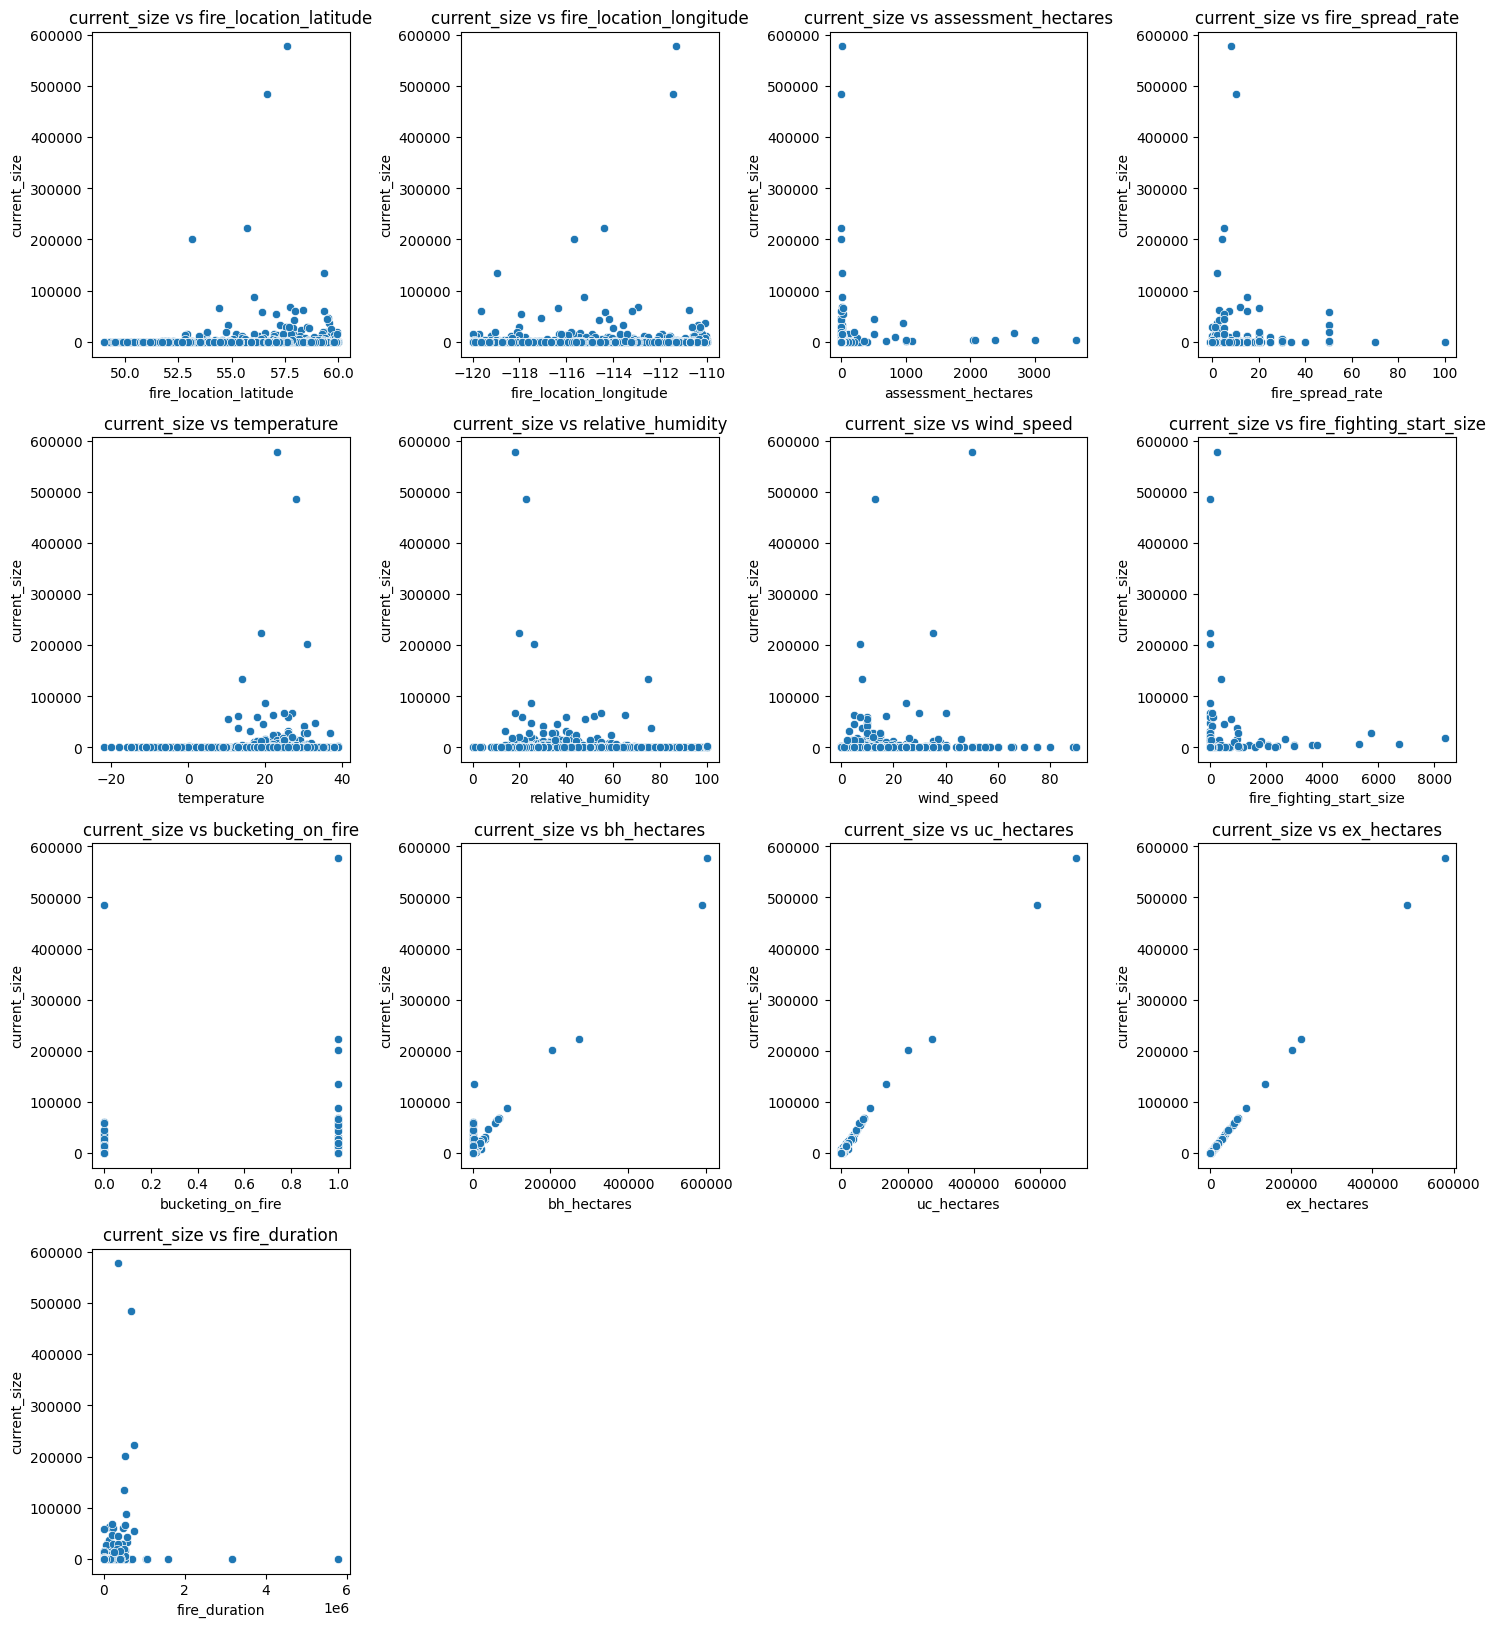

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical columns
numerical_columns = linear_reg.select_dtypes(include=['float64', 'int64']).columns

# Remove 'current_size' from the list to avoid plotting it against itself
numerical_columns = numerical_columns.drop('current_size')

# Create scatter plots
plt.figure(figsize=(15, 20))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(5, 4, i)
    sns.scatterplot(x=linear_reg[col], y=linear_reg['current_size'])
    plt.title(f'current_size vs {col}')
    plt.xlabel(col)
    plt.ylabel('current_size')
plt.tight_layout()
plt.show()

Using label encoding to encode categorical columns

In [ ]:
# Identifying non-numerical columns
non_numerical_columns = linear_reg.select_dtypes(include=['object']).columns

# Instantiate the label encoder
label_encoder = LabelEncoder()

# Apply label encoder to each non-numerical column
for column in non_numerical_columns:
    linear_reg[column] = label_encoder.fit_transform(linear_reg[column])

# Display the first few rows of the encoded dataframe
print(linear_reg.head())

    current_size  size_class  fire_location_latitude  fire_location_longitude  \
9           0.60           1               55.027370              -111.541910   
10          0.01           0               52.005383              -115.001250   
12          0.01           0               54.068900              -117.681400   
15          0.05           0               52.750550              -116.386883   
17         65.00           3               57.264167              -117.901111   

    fire_origin  general_cause_desc     fire_start_date  det_agent_type  \
9             1                  11 2006-04-04 07:00:00               4   
10            5                   4 2006-07-03 12:00:00               4   
12            5                   4 2006-07-22 17:00:00               0   
15            5                   4 2006-07-30 00:00:00               3   
17            5                   4 2006-07-03 22:30:00               3   

    det_agent     discovered_date  ... fire_fighting_start_siz

In [ ]:
linear_reg.dtypes

current_size                           float64
size_class                               int32
fire_location_latitude                 float64
fire_location_longitude                float64
fire_origin                              int32
general_cause_desc                       int32
fire_start_date                 datetime64[ns]
det_agent_type                           int32
det_agent                                int32
discovered_date                 datetime64[ns]
reported_date                   datetime64[ns]
dispatched_resource                      int32
dispatch_date                   datetime64[ns]
start_for_fire_date             datetime64[ns]
assessment_resource                      int32
assessment_datetime             datetime64[ns]
assessment_hectares                    float64
fire_spread_rate                       float64
fire_type                                int32
fire_position_on_slope                   int32
weather_conditions_over_fire             int32
temperature  

Checking linearity and homoscedasticity 

C:\Users\rayal\AppData\Local\Temp\ipykernel_30644\2955280258.py:22: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11041.
  shapiro_results = {var: shapiro(linear_reg[var]) for var in independent_vars}


Shapiro-Wilk Test Results:
assessment_hectares: Statistic=0.02200908507708277, p-value=1.5063107734538572e-117
assessment_resource: Statistic=0.5530188636531183, p-value=1.8625356209821063e-97
bh_hectares: Statistic=0.009706142964844955, p-value=6.94368752268515e-118
bucketing_on_fire: Statistic=0.6322241404077973, p-value=9.491195371700437e-93
det_agent: Statistic=0.9534670687981109, p-value=3.7538767264234033e-50
det_agent_type: Statistic=0.7255954992923273, p-value=6.645421289392168e-86
dispatched_resource: Statistic=0.8071527147391531, p-value=5.13950076244446e-78
ex_hectares: Statistic=0.01605029422146942, p-value=1.034083253741753e-117
fire_duration: Statistic=0.10257750053231374, p-value=3.0036407110411447e-115
fire_fighting_start_size: Statistic=0.027194184685307987, p-value=2.093054009720773e-117
fire_location_latitude: Statistic=0.9776822077870428, p-value=3.2074219637359124e-38
fire_location_longitude: Statistic=0.9605928072335308, p-value=2.634071005234191e-47
fire_origin: 

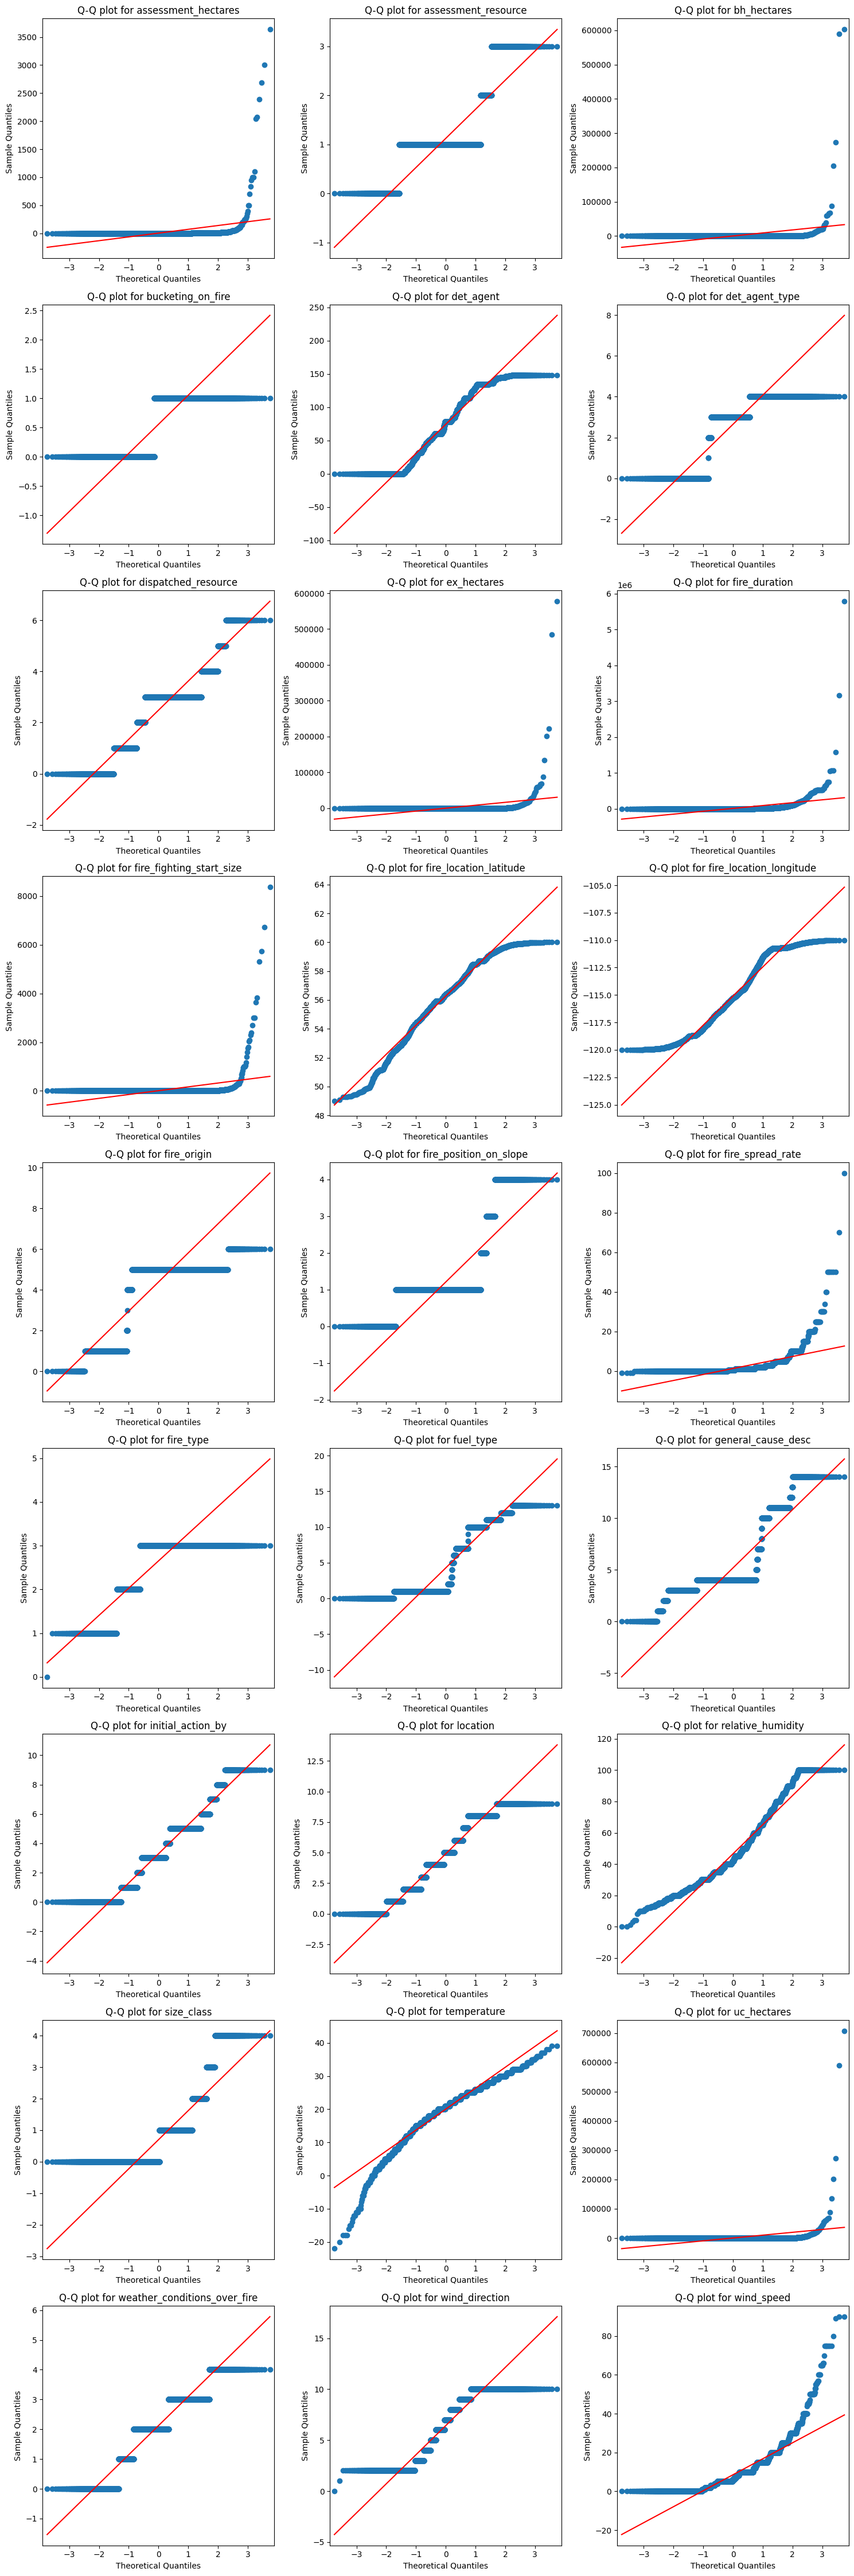

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import shapiro, norm, kstest
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats.mstats import normaltest

# Dropping datetime columns if present
datetime_columns = linear_reg.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
linear_reg = linear_reg.drop(columns=datetime_columns)

# Define the dependent variable
dependent_var = 'current_size'

# List of independent variables
independent_vars = linear_reg.columns.difference([dependent_var])

# 1. Shapiro-Wilk Test for Individual Variables
shapiro_results = {var: shapiro(linear_reg[var]) for var in independent_vars}
print("Shapiro-Wilk Test Results:")
for var, result in shapiro_results.items():
    print(f"{var}: Statistic={result[0]}, p-value={result[1]}")

# 2. Q-Q Plots as subplots
num_vars = len(independent_vars)
num_cols = 3
num_rows = (num_vars // num_cols) + (num_vars % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

for idx, var in enumerate(independent_vars):
    row, col = divmod(idx, num_cols)
    sm.qqplot(linear_reg[var], line='s', ax=axes[row, col])
    axes[row, col].set_title(f'Q-Q plot for {var}')

# Hide any unused subplots
for i in range(idx + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


In [ ]:
linear_reg.shape

(11041, 28)

Almost all variables exhibit significant deviation from normality. This non-normality can affect the assumptions of linear regression and other parametric tests that assume normality.

In [ ]:
from scipy.stats import boxcox

# Dropping datetime columns if present
datetime_columns = linear_reg.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
linear_reg = linear_reg.drop(columns=datetime_columns)
# Apply the Box-Cox transformation to each non-negative variable
for column in linear_reg.columns:
    if (linear_reg[column] > 0).all():
        linear_reg[column], fitted_lambda = boxcox(linear_reg[column] + 1e-6)  # Add small value to avoid zero
        print(f"Transformed {column} with lambda = {fitted_lambda}")

# Display the transformed dataframe
print(linear_reg.head())

# 1. Shapiro-Wilk Test for Transformed Variables
shapiro_results_transformed = {var: shapiro(linear_reg[var]) for var in linear_reg.columns}
print("Shapiro-Wilk Test Results for Transformed Variables:")
for var, result in shapiro_results_transformed.items():
    print(f"{var}: Statistic={result[0]}, p-value={result[1]}")


Transformed current_size with lambda = -0.15997186731967622
Transformed fire_location_latitude with lambda = 6.037949766059304
Transformed assessment_hectares with lambda = -0.12782836839234885
Transformed fire_fighting_start_size with lambda = -0.13127796657346036
Transformed bh_hectares with lambda = -0.15872311280547766
Transformed uc_hectares with lambda = -0.16027382492855408
Transformed ex_hectares with lambda = -0.15997186731967622
Transformed fire_duration with lambda = -0.0551148319132061
    current_size  size_class  fire_location_latitude  fire_location_longitude  \
9      -0.532276           1            5.353498e+09              -111.541910   
10     -6.807397           0            3.806484e+09              -115.001250   
12     -6.807397           0            4.814606e+09              -117.681400   
15     -3.843363           0            4.147922e+09              -116.386883   
17      3.045264           3            6.809567e+09              -117.901111   

    fire_o

C:\Users\rayal\AppData\Local\Temp\ipykernel_30644\2245479021.py:16: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11041.
  shapiro_results_transformed = {var: shapiro(linear_reg[var]) for var in linear_reg.columns}



Despite applying the Box-Cox transformation, the majority of the variables in the dataset remain non-normal according to the Shapiro-Wilk test results. While some variables, such as fire_location_latitude and fire_duration, showed improved normality, most variables still exhibit significant deviation from normality. Variables like general_cause_desc, fire_origin, det_agent_type, dispatched_resource, and assessment_resource did not show substantial improvement in their normality. 

Lets check for multicollinearity  

In [ ]:
X=linear_reg.drop(columns=['current_size'])
X = sm.add_constant(X)

In [ ]:

# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Function to iteratively remove features with high VIF
def eliminate_high_vif(df, threshold=5.0):
    while True:
        vif_df = calculate_vif(df)
        max_vif = vif_df['VIF'].max()
        if max_vif > threshold:
            feature_to_remove = vif_df.sort_values('VIF', ascending=False).iloc[0]['feature']
            print(f'Removing {feature_to_remove} with VIF {max_vif}')
            df = df.drop(columns=[feature_to_remove])
        else:
            break
    return df, vif_df

# Eliminate variables with VIF above the threshold
vif_cleaned, final_vif_df = eliminate_high_vif(X, threshold=10.0)

# Print final VIF values
print(final_vif_df)

Removing const with VIF 2016.8397723939183
Removing fire_location_longitude with VIF 188.66376366159864
Removing uc_hectares with VIF 61.65537235029991
Removing bh_hectares with VIF 27.412215760105838
Removing fire_duration with VIF 27.359535479246784
Removing fire_location_latitude with VIF 22.844044617348477
Removing ex_hectares with VIF 19.076264192030447
Removing fire_type with VIF 17.151265931560868
Removing fire_origin with VIF 14.356044513681574
Removing fire_fighting_start_size with VIF 13.238385761944532
Removing temperature with VIF 10.92130023192936
                         feature       VIF
0                     size_class  3.305672
1             general_cause_desc  4.866076
2                 det_agent_type  4.341243
3                      det_agent  3.723878
4            dispatched_resource  8.500830
5            assessment_resource  4.385566
6            assessment_hectares  4.162484
7               fire_spread_rate  1.537048
8         fire_position_on_slope  3.284162
9  

In [ ]:

# Perform linear regression with the cleaned VIF frame
y = linear_reg['current_size']  # Assuming 'current_size' is the target variable
model = sm.OLS(y, vif_cleaned).fit()

# Print the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:           current_size   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                              7892.
Date:                Tue, 02 Jul 2024   Prob (F-statistic):                        0.00
Time:                        22:14:59   Log-Likelihood:                         -17489.
No. Observations:               11041   AIC:                                  3.501e+04
Df Residuals:                   11024   BIC:                                  3.514e+04
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------